## Code to interpolate ERA5 fields to nested WRF domain and compute RMSE using ASCAT observations to validate simulations:

#### Loading Python modules:

In [1]:
import numpy as np
import numpy 
from netCDF4 import Dataset
import csv
import glob 
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import os
from mpl_toolkits.basemap import Basemap
from scipy.ndimage.filters import gaussian_filter
from wrf import ALL_TIMES
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
cartopy_ylim, latlon_coords)
from wrf import getvar, interplevel, interpz3d
import matplotlib.colors as mcolors
import pygrib
import cfgrib
from datetime import datetime
from datetime import datetime, timedelta
from scipy.interpolate import griddata
import pickle
from scipy.spatial import cKDTree

/etc/ecmwf/ssd/ssd1/tmpdirs/bidc.1009146.20240627_120011.612/ipykernel_1032472/3306146100.py:11: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


#### Defining function to obtain initial and end date for each cyclone:

In [3]:
def get_cyclone_dates(folder_wrf_path, cyc_num):
    
    # Listing sorted WRF files:
    file_name = folder_wrf_path+'medCYC_{:04d}_d02*_00_00'.format(cyc_num)
    files = np.sort(glob.glob(file_name))
    
    # Initialize variables to store the earliest and latest dates
    earliest_date = None
    latest_date = None

    # Loop through the filenames
    for file_name in files:
        # Extract the date part from the filename
        parts = file_name.split('_')
        date_str = parts[4] + ' ' + parts[5]  + parts[6] + parts[7] # Combine date and time parts
        # Convert the string to a datetime object
        date = datetime.strptime(date_str, '%Y-%m-%d %H%M%S')

        # Update earliest and latest dates
        if earliest_date is None or date < earliest_date:
            earliest_date = date
        if latest_date is None or date > latest_date:
            latest_date = date

    # Print the results
    print("Earliest date:", earliest_date)
    print("Latest date:", latest_date)

    return files, earliest_date, latest_date

#### Defining function to create hourly dates from the first initial date to the final date:

In [4]:
def generate_dates(earliest_date, latest_date):
    # Define the start and end dates
    start_date = earliest_date
    end_date = latest_date

    # Initialize the current date as the start date
    current_date = start_date

    # List to hold all the dates
    date_list = []

    # Loop through from start date to end date
    while current_date <= end_date:
        date_list.append(current_date)
        # Increment the current date by one hour
        current_date += timedelta(hours=1)
    
    return(date_list)

#### Defining interpolation function:

In [5]:
def wspeed_CopernicusInterpolation2wrf(files,date_list,interp_method) :
    # Initialize variables:
    ds_wrf = xr.open_dataset(files[0])
    ydims = ds_wrf.dims['south_north']
    xdims = ds_wrf.dims['west_east']
    ws_interp_copernicus = np.zeros(shape=(np.shape(date_list)[0],xdims,ydims))
    wind_speed_wrf = np.zeros(shape=(np.shape(date_list)[0],xdims,ydims))
    lat_wrf = np.zeros(shape=(np.shape(date_list)[0],xdims,ydims))
    lon_wrf = np.zeros(shape=(np.shape(date_list)[0],xdims,ydims))
    print(np.shape(lat_wrf))
    # Interpolating fields for each time step:
    tt = 0
    for date in date_list:
        print('time_step: ',tt, ', date: ', date)
        #
        # Opening Copernicus and WRF files:
        #
        filename_copernicus = f"cmems_obs-wind_CYC_{cyc_num:04d}.nc"
        filename_wrf = f"medCYC_{cyc_num:04d}_d02_{date.year}-{date.month:02d}-{date.day:02d}_{date.hour:02d}_00_00"
        #filename_wrf = f"medCYC_{cyc_num:04d}_d02_2009-03-08_13_00_00"
        ds_copernicus = xr.open_dataset(folder_copernicus_path + filename_copernicus)
        ds_wrf = xr.open_dataset(folder_wrf_path + filename_wrf)
        print(filename_copernicus)
        print(filename_wrf)
        print('')
        #
        # Getting variables of interest from WRF:
        #
        lat_wrf = ds_wrf['XLAT']
        lon_wrf = ds_wrf['XLONG']
        u10_wrf = ds_wrf['U10']
        v10_wrf = ds_wrf['V10']
        # Computing wind speed:
        wind_speed_wrf[tt,:,:] = np.sqrt(u10_wrf**2 + v10_wrf**2)
        #
        # Getting variables of interest from Copernicus:
        #
        lat_copernicus = ds_copernicus['latitude']
        lon_copernicus = ds_copernicus['longitude']
        # Transform 1-dim lon_copernicus and lat_copernicus arrays to 2-dim arrays:
        [lons_copernicus,lats_copernicus] = np.meshgrid(lon_copernicus,lat_copernicus)
        u10_copernicus = ds_copernicus['eastward_wind'][tt,:,:]
        v10_copernicus = ds_copernicus['northward_wind'][tt,:,:]
        # Computing wind speed:
        wind_speed_copernicus = np.sqrt(u10_copernicus**2 + v10_copernicus**2)
        #
        # Interpolate Copernicus fields to inner domain WRF:
        #
        grid_x = np.hstack(lon_wrf)
        grid_y = np.hstack(lat_wrf)
        grid_copernicus_x = np.hstack(lons_copernicus)
        grid_copernicus_y = np.hstack(lats_copernicus)
        grid = np.c_[grid_copernicus_x,grid_copernicus_y]
        ws_copernicus = np.hstack(wind_speed_copernicus)
        # Cubic-Spline Interpolation:
        wind_speed_interp_copernicus = griddata(grid, ws_copernicus, (grid_x, grid_y), method=interp_method)
        ws_interp_copernicus[tt,:,:] = np.reshape(wind_speed_interp_copernicus,(np.shape(wind_speed_wrf[tt,:,:])[0],np.shape(wind_speed_wrf[tt,:,:])[1]))
        tt = tt + 1
    return ws_interp_copernicus,wind_speed_wrf,lat_wrf,lon_wrf

#### Here goes CODE to check if there ASCAT observations within nested WRF domain [OLD VERSION]:

In [6]:
def ASCAT_Availability_Check_Old(ASCAT_path,file_name_ASCAT,WRF_path,file_name_WRF):
    #
    # Loading ASCAT geographical coordinates:
    #
    ascat_obs     = Dataset(ASCAT_path+'/'+file_name_ASCAT)
    lat_obs       = ascat_obs['lat'][:,:].data
    lon_obs       = ascat_obs['lon'][:,:].data
    #
    # Loading WRF geographical coordinates:
    #
    data_wrf      = Dataset(WRF_path+'/'+file_name_WRF)
    lat_wrf       = data_wrf['XLAT'][0,:,:].data
    lon_wrf       = data_wrf['XLONG'][0,:,:].data
    
  
    # 
    # Define the bounding box for the model domain
    #
    wrf_lat_min, wrf_lat_max = np.min(lat_wrf), np.max(lat_wrf)
    wrf_lon_min, wrf_lon_max = np.min(lon_wrf), np.max(lon_wrf)
    #
    # Check if any observation points fall within the model domain
    #                   
    obs_within_wrf_domain = (lat_obs >= wrf_lat_min) & (lat_obs <= wrf_lat_max) & \
                            (lon_obs >= wrf_lon_min) & (lon_obs <= wrf_lon_max)
    #                       
    # Check the fraction of observation points within the model domain
    #
    total_obs_points      = lat_obs.size
    fraction_within_model = np.sum(obs_within_wrf_domain) / total_obs_points
    #
    #print(f"       Fraction of observations within model domain: {fraction_within_model:.2%}")
    #
    #if np.any(obs_within_wrf_domain):
    #    print("       Some observation points fall within the model domain.")
    #else:
    #    print("       No observation points fall within the model domain. This ASCAT file is neglected.")
    return fraction_within_model

#### Here goes CODE to check if there ASCAT observations within nested WRF domain:

In [7]:
def ASCAT_Availability_Check(file_EUMETSAT_path,file,folder_wrf_path,filename_wrf):
    #
    # Paths and filenames:
    #
    fraction_threshold = 0.04   # 40% obs coverage threshold
    delta_mesh         = 0.11  # grid size common mesh in degrees. 0.11 degrees ~ 12 km
    distance_threshold = 0.1   # distance threshold to calculate distances to the nearest observation point
    #
    # Loading ASCAT geographical coordinates:
    #
    ascat_obs    = Dataset(file_EUMETSAT_path + '/' + file)
    lat_obs      = ascat_obs['lat'][:,:].data
    lon_obs      = ascat_obs['lon'][:,:].data
    ascat_values = ascat_obs['wind_speed'][:,:].data  # Replace 'variable_name' with the actual variable
    print('Total number of ASCAT observations in the globe: ', np.shape(lat_obs), lat_obs.size)
    print('Size ASCAT wind speed values:', np.shape(ascat_values))
    #
    # Loading WRF geographical coordinates:
    #
    data_wrf   = Dataset(folder_wrf_path + '/' + filename_wrf)
    lat_wrf    = data_wrf['XLAT'][0,:,:].data
    lon_wrf    = data_wrf['XLONG'][0,:,:].data
    u10m_wrf   = data_wrf['U10'][0,:,:].data
    v10m_wrf   = data_wrf['V10'][0,:,:].data
    wspeed_wrf = np.sqrt(u10m_wrf**2 + v10m_wrf**2)
    print('Size wrf domain: ', np.shape(lat_wrf))
    #
    # Define the bounding box for the model domain:
    #
    wrf_lat_min, wrf_lat_max = np.min(lat_wrf), np.max(lat_wrf)
    wrf_lon_min, wrf_lon_max = np.min(lon_wrf), np.max(lon_wrf)
    #
    # Filter observations within the model domain:
    #
    mask_obs = (lat_obs >= wrf_lat_min) & (lat_obs <= wrf_lat_max) & (lon_obs >= wrf_lon_min) & (lon_obs <= wrf_lon_max) & (ascat_values >= -500)
    lat_obs_filtered      = lat_obs[mask_obs]
    lon_obs_filtered      = lon_obs[mask_obs]
    ascat_values_filtered = ascat_values[mask_obs]
    print('Number of ASCAT observations within numerical model: ', lat_obs_filtered.size)
    #print('Minimum and Maximum values of ASCAT observations: ', np.min(ascat_values_filtered),np.max(ascat_values_filtered))
    if lat_obs_filtered.size > 100:
        #
        # Interpolate to a common grid to compute later the fraction of observations that covers the numerical domain:
        #
        #x_reg           = np.linspace(wrf_lon_min,wrf_lon_max,np.shape(lon_wrf)[0])
        #y_reg           = np.linspace(wrf_lat_min,wrf_lat_max,np.shape(lat_wrf)[0])
        x_reg           = np.arange(wrf_lon_min, wrf_lon_max, delta_mesh)  # 0.11 degrees ~ 12 km
        y_reg           = np.arange(wrf_lat_min, wrf_lat_max, delta_mesh)  # 0.11 degrees ~ 12 km
        lon_reg,lat_reg = np.meshgrid(x_reg,y_reg)
        #print('lat_reg:', lat_reg[0,0:10],np.shape(lat_reg))
        #print('lon_reg:', lon_reg[0,0:10],np.shape(lon_reg))
        #
        # Flatten the filtered observation and model grids for interpolation:
        #
        points_obs  = np.c_[lon_obs_filtered.flatten(), lat_obs_filtered.flatten()]
        points_wrf  = np.c_[lon_wrf.flatten(), lat_wrf.flatten()]
        ##values_obs  = ascat_values_filtered.flatten()
        values_obs  = np.ones(lon_obs_filtered.flatten().shape)  # Dummy values to represent points
        values_wrf  = wspeed_wrf.flatten()
        points_mesh = np.c_[lon_reg.flatten(), lat_reg.flatten()]
        #print(np.shape(points_obs),np.shape(values_obs),np.shape(points_mesh))
        #
        # Interpolate observations onto the common grid:
        #
        grid_obs_common = griddata(points_obs, values_obs, points_mesh, method='nearest', fill_value=np.nan)
        grid_obs_mesh   = grid_obs_common.reshape(lat_reg.shape)
        #print('grid_obs_mesh: ', grid_obs_mesh, np.min(grid_obs_mesh), np.max(grid_obs_mesh))
        #
        # Calculate distances to the nearest observation point
        #
        tree               = cKDTree(points_obs)
        distances, _       = tree.query(points_mesh, k=1)
        distance_threshold = distance_threshold  # Set an appropriate threshold distance
        #
        # Mask the interpolated grid based on the distance to the nearest observation point
        #
        grid_obs_mesh[distances.reshape(lat_reg.shape) > distance_threshold] = np.nan
        #print('grid_obs_mesh: ', grid_obs_mesh, np.min(grid_obs_mesh), np.max(grid_obs_mesh))
        #
        # Separate valid and NaN values:
        #
        valid_mask       = ~np.isnan(grid_obs_mesh)
        nan_mask         = np.isnan(grid_obs_mesh)
        x_valid, y_valid = lon_reg[valid_mask], lat_reg[valid_mask]
        x_nan, y_nan     = lon_reg[nan_mask], lat_reg[nan_mask]
        #print('Valid mask size: ', np.shape(x_valid),np.shape(x_nan))
        #
        #                       
        # Check the fraction of observation points within the model domain
        #
        total_mesh_points      = lon_reg.size
        fraction_within_mesh   = np.sum(x_valid.size) / total_mesh_points
        #print('Valid obs size: ', x_valid.size, total_mesh_points)
        print('Fraction of observations within mesh domain: ',fraction_within_mesh)
        print(f"Fraction of observations within mesh domain: {fraction_within_mesh:.2%}")
        if fraction_within_mesh > fraction_threshold:
            #
            # =========================================================
            # Plotting:
            # =========================================================
            #
            # Create the Basemap instance:
            #
            m = Basemap(projection='cyl', resolution='l',
                        llcrnrlat=wrf_lat_min, urcrnrlat=wrf_lat_max,
                        llcrnrlon=wrf_lon_min, urcrnrlon=wrf_lon_max)
            #
            # Plotting the data:
            #
            fig = plt.figure(figsize=(8,10))
            ax = fig.add_subplot(111)
            m.drawcoastlines(color="black", linewidth=1)
            m.drawstates(linestyle="dotted")
            m.drawcountries(linestyle="dotted")
            parallels = np.arange(-90, 90, 10)
            meridians = np.arange(0, 360, 10)
            m.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10, linewidth=0.5)
            m.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10, linewidth=0.5)
            # Transform coordinates for plotting
            x_reg, y_reg = m(lon_reg, lat_reg)
            x_obs, y_obs = m(lon_obs_filtered, lat_obs_filtered)
            # Scatter plot the values
            m.scatter(x_valid, y_valid, color='blue', s=0.2, label='Valid Observations')
            m.scatter(x_nan, y_nan, color='grey', s=0.2, label='NaN Observations')
            plt.legend(loc='upper right')
            plt.title('Interpolated Observations onto common grid')
            # Save the figure
            fig.savefig('Interpolated_Observations_onto_common_grid_'+ filename_wrf +'.png', dpi=300)
            #plt.show()
    else:
        fraction_within_mesh = 0
    return fraction_within_mesh

#### Here goes CODE to interpolate ASCAT observations to same grid model:

In [8]:
def Computing_RMSE_and_Plotting_Winds(ASCAT_path,file_name_ASCAT,WRF_path,file_name_WRF,ERA5_path,file_name_ERA5):
    #
    # Loading ASCAT geographical coordinates:
    #
    ascat_obs       = Dataset(ASCAT_path + '/' + file_name_ASCAT)
    lat_obs         = ascat_obs['lat'][:,:].data
    lon_obs         = ascat_obs['lon'][:,:].data
    ascat_wspeed10m = ascat_obs['wind_speed'][:,:].data  # Replace 'variable_name' with the actual variable
    ascat_wdir10m   = ascat_obs['wind_dir'][:,:].data  # Replace 'variable_name' with the actual variable
    #
    # Loading ERA5 geographical coordinates:
    #
    #Opening ERA5 Grib files:
    ds = xr.open_dataset(ERA5_path + '/' + file_name_ERA5, engine='cfgrib',backend_kwargs={'errors': 'ignore'})
    # Obtaining variables of interest from ERA5 files:
    lat_era5 = ds['latitude']
    lon_era5 = ds['longitude']
    u10m_era5 = ds['u10'].values
    v10m_era5 = ds['v10'].values
    # Computing wind speed:
    wspeed_era5 = np.sqrt(u10m_era5**2 + v10m_era5**2)
    # Transform 1-dim lon_era5 and lat_era5 arrays to 2-dim arrays:
    [lons_era5,lats_era5] = np.meshgrid(lon_era5,lat_era5)
    #
    # Loading WRF geographical coordinates:
    #
    data_wrf   = Dataset(WRF_path + '/' + file_name_WRF)
    lat_wrf    = data_wrf['XLAT'][0,:,:].data
    lon_wrf    = data_wrf['XLONG'][0,:,:].data
    u10m_wrf   = data_wrf['U10'][0,:,:].data
    v10m_wrf   = data_wrf['V10'][0,:,:].data
    wspeed_wrf = np.sqrt(u10m_wrf**2 + v10m_wrf**2)
    #
    # Define the bounding box for the model domain:
    #
    wrf_lat_min, wrf_lat_max = np.min(lat_wrf), np.max(lat_wrf)
    wrf_lon_min, wrf_lon_max = np.min(lon_wrf), np.max(lon_wrf)
    #
    # Define mask and apply it to the observations:
    #
    mask_obs = (lat_obs >= wrf_lat_min) & (lat_obs <= wrf_lat_max) & (lon_obs >= wrf_lon_min) & (lon_obs <= wrf_lon_max) & (ascat_wspeed10m >= -500)
    lat_obs_filtered         = lat_obs[mask_obs]
    lon_obs_filtered         = lon_obs[mask_obs]
    ascat_wspeed10m_filtered = ascat_wspeed10m[mask_obs]
    ascat_wdir10m_filtered   = ascat_wdir10m[mask_obs]
    #
    # Flatten the filtered observation and model grids for interpolation:
    #
    points_obs  = np.c_[lon_obs_filtered.flatten(), lat_obs_filtered.flatten()]
    points_wrf  = np.c_[lon_wrf.flatten(), lat_wrf.flatten()]
    points_era5 = np.c_[lons_era5.flatten(), lats_era5.flatten()]
    values_era5 = wspeed_era5.flatten()
    values_wrf  = wspeed_wrf.flatten()
    points_mesh = np.c_[lon_obs_filtered.flatten(), lat_obs_filtered.flatten()]
    #
    # Interpolate wrf onto the observation grid:
    #
    wrf_interp = griddata(points_wrf, values_wrf, points_mesh, method='nearest', fill_value=np.nan)
    #
    #
    # Interpolate ERA5 onto the observation grid:
    #
    era5_interp = griddata(points_era5, values_era5, points_mesh, method='nearest', fill_value=np.nan)
    #
    # Interpolate u and v components of WRF wind to observation sites:
    #
    u10m_wrf_interp = griddata(points_wrf, u10m_wrf.flatten(), points_mesh, method='nearest', fill_value=np.nan)
    v10m_wrf_interp = griddata(points_wrf, v10m_wrf.flatten(), points_mesh, method='nearest', fill_value=np.nan)
    #
    # Interpolate u and v components of ERA5 wind to observation sites:
    #
    u10m_era5_interp = griddata(points_era5, u10m_era5.flatten(), points_mesh, method='nearest', fill_value=np.nan)
    v10m_era5_interp = griddata(points_era5, v10m_era5.flatten(), points_mesh, method='nearest', fill_value=np.nan)
    #
    # =========================================================
    # Compute RMSE:
    # =========================================================
    # Remove NaN values for RMSE computation
    valid_mask = ~np.isnan(wrf_interp) & ~np.isnan(ascat_wspeed10m_filtered)
    wrf_interp_valid      = wrf_interp[valid_mask]
    era5_interp_valid     = era5_interp[valid_mask]
    ascat_wspeed10m_valid = ascat_wspeed10m_filtered[valid_mask]
    ascat_u10m            = ascat_wspeed10m_filtered * np.cos(np.radians(90 - ascat_wdir10m_filtered))
    ascat_v10m            = ascat_wspeed10m_filtered * np.sin(np.radians(90 - ascat_wdir10m_filtered))
    #
    rmse_wspeed10m        = np.sqrt(np.mean((wrf_interp_valid - ascat_wspeed10m_valid) ** 2))
    rmse_u10m             = np.sqrt(np.mean((u10m_wrf_interp - ascat_u10m) ** 2))
    rmse_v10m             = np.sqrt(np.mean((v10m_wrf_interp - ascat_v10m) ** 2))
    rmse_era5_wspeed10m   = np.sqrt(np.mean((era5_interp_valid - ascat_wspeed10m_valid) ** 2))
    rmse_era5_u10m        = np.sqrt(np.mean((u10m_era5_interp - ascat_u10m) ** 2))
    rmse_era5_v10m        = np.sqrt(np.mean((v10m_era5_interp - ascat_v10m) ** 2))
    #
    print(f'RMSE wspeed10m between model and observations: {rmse_wspeed10m:.2f} m/s')
    print(f'RMSE ERA5 wspeed10m between model and observations: {rmse_era5_wspeed10m:.2f} m/s')
    print(f'RMSE u10m between model and observations: {rmse_u10m:.2f} m/s')
    print(f'RMSE ERA5 u10m between model and observations: {rmse_era5_u10m:.2f} m/s')
    print(f'RMSE v10m between model and observations: {rmse_v10m:.2f} m/s')
    print(f'RMSE ERA5 v10m between model and observations: {rmse_era5_v10m:.2f} m/s')
    #
    # =========================================================
    # Plotting:
    # =========================================================
    #
    # Create the Basemap instance:
    m = Basemap(projection='cyl', resolution='i',
                llcrnrlat=wrf_lat_min, urcrnrlat=wrf_lat_max,
                llcrnrlon=wrf_lon_min, urcrnrlon=wrf_lon_max)
    #
    # Plotting the data:
    #
    fig = plt.figure(figsize=(14, 14))
    #
    # First subplot: Observed wind speed and direction:
    # 
    ax1 = fig.add_subplot(311)
    m.drawcoastlines(color="black", linewidth=1)
    m.drawstates(linestyle="dotted")
    m.drawcountries(linestyle="dotted")
    parallels = np.arange(-90, 90, 10)
    meridians = np.arange(0, 360, 10)
    m.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10, linewidth=0.5)
    m.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10, linewidth=0.5)
    #
    # Transform coordinates for plotting:
    #
    x_obs, y_obs = m(lon_obs_filtered, lat_obs_filtered)
    #
    # Calculate u and v components for observed wind:
    #
    u_obs = ascat_wspeed10m_filtered * np.cos(np.radians(90 - ascat_wdir10m_filtered))
    v_obs = ascat_wspeed10m_filtered * np.sin(np.radians(90 - ascat_wdir10m_filtered))
    #
    # Plot wind barbs for observed wind speed and direction:
    #
    barb_density = 3  # Controls the density of barbs
    m.barbs(x_obs[::barb_density], y_obs[::barb_density], u_obs[::barb_density], v_obs[::barb_density], length=5, color='blue')
    plt.title('Observed Wind Speed and Direction')
    #
    # Second subplot: Interpolated WRF wind speed and direction:
    #
    ax2 = fig.add_subplot(312)
    m.drawcoastlines(color="black", linewidth=1)
    m.drawstates(linestyle="dotted")
    m.drawcountries(linestyle="dotted")
    m.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10, linewidth=0.5)
    m.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10, linewidth=0.5)
    # Plot wind barbs for interpolated WRF wind speed and direction
    barb_density = 3  # Controls the density of barbs
    m.barbs(x_obs[::barb_density], y_obs[::barb_density], u10m_wrf_interp[::barb_density], v10m_wrf_interp[::barb_density], length=5, color='red')
    plt.title('Interpolated WRF Wind Speed and Direction')
    plt.tight_layout()
    plt.show()
    #
    # Third subplot: Interpolated ERA5 wind speed and direction:
    #
    ax2 = fig.add_subplot(313)
    m.drawcoastlines(color="black", linewidth=1)
    m.drawstates(linestyle="dotted")
    m.drawcountries(linestyle="dotted")
    m.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10, linewidth=0.5)
    m.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10, linewidth=0.5)
    # Plot wind barbs for interpolated WRF wind speed and direction
    barb_density = 3  # Controls the density of barbs
    m.barbs(x_obs[::barb_density], y_obs[::barb_density], u10m_era5_interp[::barb_density], v10m_era5_interp[::barb_density], length=5, color='green')
    plt.title('Interpolated ERA5 Wind Speed and Direction')
    plt.tight_layout()
    plt.show()
    # Save the figure
    fig.savefig('Interpolated_WRFandERA5_Wind_Speed_and_Direction_'+ file_name_WRF +'.png', dpi=300)
    return rmse_wspeed10m, rmse_u10m, rmse_v10m, rmse_era5_wspeed10m, rmse_era5_u10m, rmse_era5_v10m

In [9]:
def Computing_ERA5_RMSE_and_Plotting_Winds(ASCAT_path,file_name_ASCAT,WRF_path,file_name_WRF,ERA5_path,file_name_ERA5):
    #
    # Loading ASCAT geographical coordinates:
    #
    ascat_obs       = Dataset(ASCAT_path + '/' + file_name_ASCAT)
    lat_obs         = ascat_obs['lat'][:,:].data
    lon_obs         = ascat_obs['lon'][:,:].data
    ascat_wspeed10m = ascat_obs['wind_speed'][:,:].data  # Replace 'variable_name' with the actual variable
    ascat_wdir10m   = ascat_obs['wind_dir'][:,:].data  # Replace 'variable_name' with the actual variable
    #
    # Loading ERA5 geographical coordinates:
    #
    #Opening ERA5 Grib files:
    ds = xr.open_dataset(ERA5_path + '/' + file_name_ERA5, engine='cfgrib',backend_kwargs={'errors': 'ignore'})
    # Obtaining variables of interest from ERA5 files:
    lat_era5 = ds['latitude']
    lon_era5 = ds['longitude']
    u10m_era5 = ds['u10'].values
    v10m_era5 = ds['v10'].values
    # Computing wind speed:
    wspeed_era5 = np.sqrt(u10_era5**2 + v10_era5**2)
    # Transform 1-dim lon_era5 and lat_era5 arrays to 2-dim arrays:
    [lons_era5,lats_era5] = np.meshgrid(lon_era5,lat_era5)
    print('shape wspeed_era5: ', np.shape(wspeed_era5), wspeed_era5)
    #
    # Loading WRF geographical coordinates:
    #
    data_wrf   = Dataset(WRF_path + '/' + file_name_WRF)
    lat_wrf    = data_wrf['XLAT'][0,:,:].data
    lon_wrf    = data_wrf['XLONG'][0,:,:].data
    u10m_wrf   = data_wrf['U10'][0,:,:].data
    v10m_wrf   = data_wrf['V10'][0,:,:].data
    wspeed_wrf = np.sqrt(u10m_wrf**2 + v10m_wrf**2)
    #
    # Define the bounding box for the model domain:
    #
    wrf_lat_min, wrf_lat_max = np.min(lat_wrf), np.max(lat_wrf)
    wrf_lon_min, wrf_lon_max = np.min(lon_wrf), np.max(lon_wrf)
    #
    # Define mask and apply it to the observations:
    #
    mask_obs = (lat_obs >= wrf_lat_min) & (lat_obs <= wrf_lat_max) & (lon_obs >= wrf_lon_min) & (lon_obs <= wrf_lon_max) & (ascat_wspeed10m >= -500)
    lat_obs_filtered         = lat_obs[mask_obs]
    lon_obs_filtered         = lon_obs[mask_obs]
    ascat_wspeed10m_filtered = ascat_wspeed10m[mask_obs]
    ascat_wdir10m_filtered   = ascat_wdir10m[mask_obs]
    #
    # Flatten the filtered observation and model grids for interpolation:
    #
    points_obs  = np.c_[lon_obs_filtered.flatten(), lat_obs_filtered.flatten()]
    points_era5  = np.c_[lons_era5.flatten(), lats_era5.flatten()]
    values_era5  = wspeed_era5.flatten()
    points_mesh = np.c_[lon_obs_filtered.flatten(), lat_obs_filtered.flatten()]
    #
    # Interpolate ERA5 onto the observation grid:
    #
    era5_interp = griddata(points_era5, values_era5, points_mesh, method='nearest', fill_value=np.nan)
    #
    # Interpolate u and v components of ERA5 wind to observation sites:
    #
    u10m_era5_interp = griddata(points_era5, u10m_era5.flatten(), points_mesh, method='nearest', fill_value=np.nan)
    v10m_era5_interp = griddata(points_era5, v10m_era5.flatten(), points_mesh, method='nearest', fill_value=np.nan)
    print('era5_interp: ', np.shape(era5_interp), era5_interp)
    #
    # =========================================================
    # Compute RMSE:
    # =========================================================
    # Remove NaN values for RMSE computation
    valid_mask = ~np.isnan(era5_interp) & ~np.isnan(ascat_wspeed10m_filtered)
    era5_interp_valid = era5_interp[valid_mask]
    ascat_wspeed10m_valid = ascat_wspeed10m_filtered[valid_mask]
    ascat_u10m = ascat_wspeed10m_filtered * np.cos(np.radians(90 - ascat_wdir10m_filtered))
    ascat_v10m = ascat_wspeed10m_filtered * np.sin(np.radians(90 - ascat_wdir10m_filtered))
    #
    rmse_wspeed10m = np.sqrt(np.mean((era5_interp_valid - ascat_wspeed10m_valid) ** 2))
    rmse_u10m = np.sqrt(np.mean((u10m_era5_interp - ascat_u10m) ** 2))
    rmse_v10m = np.sqrt(np.mean((v10m_era5_interp - ascat_v10m) ** 2))
    #
    print(f'RMSE wspeed10m between model and observations: {rmse_wspeed10m:.2f} m/s')
    print(f'RMSE u10m between model and observations: {rmse_u10m:.2f} m/s')
    print(f'RMSE v10m between model and observations: {rmse_v10m:.2f} m/s')
    #
    # =========================================================
    # Plotting:
    # =========================================================
    #
    # Create the Basemap instance:
    m = Basemap(projection='cyl', resolution='i',
                llcrnrlat=wrf_lat_min, urcrnrlat=wrf_lat_max,
                llcrnrlon=wrf_lon_min, urcrnrlon=wrf_lon_max)
    #
    # Plotting the data:
    #
    fig = plt.figure(figsize=(14, 10))
    #
    # First subplot: Observed wind speed and direction:
    # 
    ax1 = fig.add_subplot(121)
    m.drawcoastlines(color="black", linewidth=1)
    m.drawstates(linestyle="dotted")
    m.drawcountries(linestyle="dotted")
    parallels = np.arange(-90, 90, 10)
    meridians = np.arange(0, 360, 10)
    m.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10, linewidth=0.5)
    m.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10, linewidth=0.5)
    #
    # Transform coordinates for plotting:
    #
    x_obs, y_obs = m(lon_obs_filtered, lat_obs_filtered)
    #
    # Calculate u and v components for observed wind:
    #
    u_obs = ascat_wspeed10m_filtered * np.cos(np.radians(90 - ascat_wdir10m_filtered))
    v_obs = ascat_wspeed10m_filtered * np.sin(np.radians(90 - ascat_wdir10m_filtered))
    #
    # Plot wind barbs for observed wind speed and direction:
    #
    barb_density = 3  # Controls the density of barbs
    m.barbs(x_obs[::barb_density], y_obs[::barb_density], u_obs[::barb_density], v_obs[::barb_density], length=5, color='blue')
    plt.title('Observed Wind Speed and Direction')
    #
    # Second subplot: Interpolated ERA5 wind speed and direction:
    #
    ax2 = fig.add_subplot(122)
    m.drawcoastlines(color="black", linewidth=1)
    m.drawstates(linestyle="dotted")
    m.drawcountries(linestyle="dotted")
    m.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10, linewidth=0.5)
    m.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10, linewidth=0.5)
    # Plot wind barbs for interpolated WRF wind speed and direction
    barb_density = 3  # Controls the density of barbs
    m.barbs(x_obs[::barb_density], y_obs[::barb_density], u10m_era5_interp[::barb_density], v10m_era5_interp[::barb_density], length=5, color='red')
    plt.title('Interpolated ERA5 Wind Speed and Direction')
    plt.tight_layout()
    plt.show()
    # Save the figure
    fig.savefig('Interpolated_ERA5_Wind_Speed_and_Direction_'+ file_name_WRF +'.png', dpi=300)
    return rmse_wspeed10m, rmse_u10m, rmse_v10m

#### Defining Plot Check to compare ASCAT and nested WRF domain coverage:

In [10]:
def Plot_Check_ASCATvsWRF(mapa,ASCAT_path,file_name_ASCAT,WRF_path,file_name_WRF,cyc_num,date_cyclone):
    #
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.ndimage import gaussian_filter
    import matplotlib
    #
    # Loading ASCAT geographical coordinates:
    #
    ascat_obs     = Dataset(ASCAT_path+'/'+file_name_ASCAT)
    lat_obs       = ascat_obs['lat'][:,:].data
    lon_obs       = ascat_obs['lon'][:,:].data
    #
    # Loading WRF geographical coordinates:
    #
    data_wrf      = Dataset(WRF_path+'/'+file_name_WRF)
    lat_wrf       = data_wrf['XLAT'][0,:,:].data
    lon_wrf       = data_wrf['XLONG'][0,:,:].data

    # Loading basemap:
    #m_d02 = Basemap(projection='cyl', resolution='c')
    m_d02 = Basemap(projection='robin', resolution='c', lon_0=0)

    # Increase the resolution of the output
    matplotlib.rcParams['figure.dpi'] = 100

    # Create the figure with a larger size for better visualization
    fig = plt.figure(figsize=(12, 14))
    ax = fig.add_subplot(111)

    # Customize the map details
    parallels = np.arange(-90, 90, 20)
    meridians = np.arange(0, 360, 40)
    m_d02.drawcoastlines(color="black", linewidth=1)
    m_d02.drawstates(linestyle="dotted")
    m_d02.drawcountries(linestyle="dotted")
    m_d02.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10, linewidth=0.5)
    m_d02.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10, linewidth=0.5)

    # Transform coordinates for plotting
    x_obs, y_obs  = m_d02(lon_obs, lat_obs)
    x_wrf, y_wrf  = m_d02(lon_wrf, lat_wrf)

    # Plotting scatter plots:
    cs1 = m_d02.scatter(x_wrf[::6], y_wrf[::6], color='red', label='WRF Model', s=1)
    cs2 = m_d02.scatter(x_obs[::6], y_obs[::6], color='blue',  label='ASCAT Obs', s=1)

    # Title figure:
    plt.title('Spatial Distribution ASCAT Observations (CYC:'+str(cyc_num)+') \n valid at '+str(date_cyclone.strftime('%d-%b-%Y %H:%M:%S')), fontsize=14)
    plt.legend(loc='lower left')

    # Save the figure
    #fig.savefig('Spatial_Distribution_ASCAT_Observations_(CYC:'+str(cyc_num)+')_'+str(date_cyclone.strftime('%d-%b-%Y %H:%M:%S'))+'.png', dpi=300)
    fig.savefig('Spatial_Distribution_ASCAT_Observations_(CYC:'+str(cyc_num)+').png', dpi=300)


#### Defining plot function:

In [11]:
def plot_ERA5vsWRF(t_index,date_list,lon_wrf,lat_wrf,ws_interp_era5,wind_speed_wrf,m_d01):
    from matplotlib import cm
    fig = plt.figure(figsize=(12,13))
    # Subplot 1: ERA5
    ax = fig.add_subplot(211)
    parallels = np.arange(-90,90,5)
    meridians = np.arange(0,360,5)
    m_d01.drawcoastlines(color="black",linewidth=0.5)
    m_d01.drawstates(linestyle="dotted")
    m_d01.drawcountries(linestyle="dotted")
    m_d01.drawparallels(parallels,labels=[1,0,0,0],fontsize=8,linewidth=.7)
    m_d01.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8,linewidth=.7)
    x, y = m_d01(lon_wrf[t_index,:,:],lat_wrf[t_index,:,:]) # compute map proj coordinates of the grid points
    clevs=np.arange(0,20,2)
    cs1 = m_d01.contourf(x,y,ws_interp_era5[t_index,:,:],clevs,cmap=plt.cm.jet,extend='both')
    plt.colorbar(cs1, label= 'Wind Speed',fraction=0.023,pad=0.04)
    fig.tight_layout()
    plt.title(f"ERA5 Wind Speed at 10 m Interpolated at \n {date_list[t_index].strftime('%Y-%m-%d %H:%M:%S')}")
    #
    ###############################################
    # Subplot 2: WRF
    ax = fig.add_subplot(212)
    parallels = np.arange(-90,90,5)
    meridians = np.arange(0,360,5)
    m_d01.drawcoastlines(color="black",linewidth=0.5)
    m_d01.drawstates(linestyle="dotted")
    m_d01.drawcountries(linestyle="dotted")
    m_d01.drawparallels(parallels,labels=[1,0,0,0],fontsize=8,linewidth=.7)
    m_d01.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8,linewidth=.7)
    x, y = m_d01(lon_wrf[t_index,:,:],lat_wrf[t_index,:,:]) # compute map proj coordinates of the grid points
    cs1 = m_d01.contourf(x,y,wind_speed_wrf[t_index,:,:],clevs,cmap=plt.cm.jet,extend='both')
    plt.colorbar(cs1, label= 'Wind Speed',fraction=0.023,pad=0.04)
    plt.title(f"WRF Wind Speed at 10 m at \n {date_list[t_index].strftime('%Y-%m-%d %H:%M:%S')}")
    # Adjust layout
    fig.subplots_adjust(wspace=0.01)  # Adjust the vertical space between the subplots
    #plt.tight_layout()
    #plt.show()


In [12]:
def Interpolation_and_RMSE(earliest_date,latest_date,cyc_num,mapa):
    start_year    = f"{earliest_date.year:04d}"
    start_month   = f"{earliest_date.month:02d}"
    start_day     = f"{earliest_date.day:02d}"
    start_hour    = f"{earliest_date.hour:02d}"
    start_minute  = "00"
    start_seconds = "00"
    #
    end_year    = f"{latest_date.year:04d}"
    end_month   = f"{latest_date.month:02d}"
    end_day     = f"{latest_date.day:02d}"
    end_hour    = f"{latest_date.hour:02d}"
    end_minute  = "00"
    end_seconds = "00"
    #
    start_YMD_date    = earliest_date.strftime("%Y-%m-%d")
    end_YMD_date      = f"{end_year}{end_month}{end_day}"
    start_date_format = f"{start_year}-{start_month}-{start_day}T{start_hour}:{start_minute}:{start_seconds}"
    end_date_format   = f"{end_year}-{end_month}-{end_day}T{end_hour}:{end_minute}:{end_seconds}"
    day_of_the_year = earliest_date.timetuple().tm_yday
    filename = f"cmems_obs-wind_CYC_{cyc_num:04d}.nc"
    #
    # Initializing lists:
    rmse_wspeed10m_cyc      = []
    rmse_u10m_cyc           = []
    rmse_v10m_cyc           = []
    rmse_era5_wspeed10m_cyc = []
    rmse_era5_u10m_cyc      = []
    rmse_era5_v10m_cyc      = []
    import datetime as datetime2
    if earliest_date < datetime2.datetime(2010, 7, 1) or latest_date > datetime2.datetime(2021, 12, 1):
        print("EUMETSAT Data is only available from 1 July 2010 onwards.")
        print("EUMETSAT Data for cyclone #"+str(cyc_num)+" will be not obtained.")
        rmse_wspeed10m_cyc.append(np.nan)
    else:
        #
        # Reading ASCAT observations:
        #
        print("ASCAT observations available in the COPERNICUS database.")
        folder_EUMETSAT_path = '/scratch/bidc/DCC/EUMETSAT_Obs'
        file_EUMETSAT_path = f"{folder_EUMETSAT_path}/{start_year}/CYC_{cyc_num}/{day_of_the_year:03d}"
        folder_wrf_path = '/scratch/bidc/DCC/medTRACK_{:04d}/'.format(cyc_num)
        folder_era5_path = '/scratch/bidc/DCC/CYC_{:01d}/'.format(cyc_num)
        # Selecting the ASCAT files available at the same Cyclone period of time
        for date in date_list:
            print('  Date: ', date)
            filename_wrf = f"medCYC_{cyc_num:04d}_d02_{date.year}-{date.month:02d}-{date.day:02d}_{date.hour:02d}_00_00"
            filename_era5 = f"ERA5_AN_{date.year}{date.month:02d}{date.day:02d}_{date.hour:02d}00_sfc"
            folder_EUMETSAT_path = '/scratch/bidc/DCC/EUMETSAT_Obs'
            day_of_the_year = date.timetuple().tm_yday
            file_EUMETSAT_path = f"{folder_EUMETSAT_path}/{start_year}/CYC_{cyc_num}/{day_of_the_year:03d}"
            print('  File EUMETSAT path: ',  file_EUMETSAT_path)
            print('  Day of the year: ',  day_of_the_year)
            files_ascat = os.listdir(file_EUMETSAT_path)
            # Let's select the ascat file closer to the time of the cyclone:
            for file in files_ascat:
                if file.startswith(f"ascat_{date.year}{date.month:02d}{date.day:02d}_{date.hour:02d}"):
                    print('      ASCAT file found matching cyclone time:', file)
                    # Here goes CODE to check if ASCAT observations fall within model domain:
                    fraction_obs_within_wrf = ASCAT_Availability_Check(file_EUMETSAT_path,file,folder_wrf_path,filename_wrf)
                    print(f"          Fraction of observations within model domain: {fraction_obs_within_wrf:.2%}")
                    if fraction_obs_within_wrf < 0.04:
                        print('          There are NO enough ASCAT observations in the nested WRF domain to be considered. We neglect this ASCAT file!')
                    else:
                        print('          There are ENOUGH ASCAT observations in the nested WRF domain to be considered. We proceed with the interpolation!')
                        print('          Plotting ASCAT observations and nested WRF domain coverage')
                        Plot_Check_ASCATvsWRF(mapa,file_EUMETSAT_path,file,folder_wrf_path,filename_wrf,cyc_num,date)
                        # Here goes CODE to validate ERA5 and WRF nested simulations using ASCAT observations:
                        [rmse_wspeed10m, rmse_u10m, rmse_v10m, rmse_era5_wspeed10m, rmse_era5_u10m, rmse_era5_v10m] = Computing_RMSE_and_Plotting_Winds(file_EUMETSAT_path,file,folder_wrf_path,filename_wrf,folder_era5_path,filename_era5)
                        rmse_wspeed10m_cyc.append(rmse_wspeed10m)
                        rmse_u10m_cyc.append(rmse_u10m)
                        rmse_v10m_cyc.append(rmse_v10m)
                        rmse_era5_wspeed10m_cyc.append(rmse_era5_wspeed10m)
                        rmse_era5_u10m_cyc.append(rmse_era5_u10m)
                        rmse_era5_v10m_cyc.append(rmse_era5_v10m)
    return rmse_wspeed10m_cyc,rmse_u10m_cyc,rmse_v10m_cyc,rmse_era5_wspeed10m_cyc,rmse_era5_u10m_cyc,rmse_era5_v10m_cyc

## -------------------------- START CODE -------------------------- ##

#### Enter to the work directory where the figures will be stored:

In [14]:
cd /scratch/bidc/DCC/EUMETSAT_Obs/

/lus/h2resw01/scratch/bidc/DCC/EUMETSAT_Obs


#### Validating ERA5 and WRF nested simulations using ASCAT observations:

In [ ]:
import sys
import os

#cyc_tot = 201    # Entire cyclones database
cyc_tot = 10    # Entire cyclones database

mapa_d02 = Basemap(projection='robin', resolution='c', lon_0=0)

# Initializing lists:
rmse_wspeed10m_cyc_array      = []
rmse_u10m_cyc_array           = []
rmse_v10m_cyc_array           = []
rmse_era5_wspeed10m_cyc_array = []
rmse_era5_u10m_cyc_array      = []
rmse_era5_v10m_cyc_array      = []

for cyc_num in range(1,cyc_tot):
    print ('') 
    print('CYCLONE NUMBER: ', cyc_num)
 
    # Folder WRF path:
    folder_wrf_path = '/scratch/bidc/DCC/medTRACK_{:04d}/'.format(cyc_num)

    # Select range of times for each Cyclone simulation:
    [files, earliest_date,latest_date] = get_cyclone_dates(folder_wrf_path, cyc_num)

    # Generate Dates every hour:
    date_list = generate_dates(earliest_date,latest_date)
    
    if cyc_num > 8:
        break
    
    # Interpolating Copernicus and ERA5 fields to WRF nested domain and compute RMSE:
    rmse_wspeed10m_cyc,rmse_u10m_cyc,rmse_v10m_cyc,rmse_era5_wspeed10m_cyc,rmse_era5_u10m_cyc,rmse_era5_v10m_cyc = Interpolation_and_RMSE(earliest_date,latest_date,cyc_num,mapa_d02)
    rmse_wspeed10m_cyc_array.append(rmse_wspeed10m_cyc)
    rmse_u10m_cyc_array.append(rmse_u10m_cyc)
    rmse_v10m_cyc_array.append(rmse_v10m_cyc)
    rmse_era5_wspeed10m_cyc_array.append(rmse_era5_wspeed10m_cyc)
    rmse_era5_u10m_cyc_array.append(rmse_era5_u10m_cyc)
    rmse_era5_v10m_cyc_array.append(rmse_era5_v10m_cyc)


# -------------------------------------------------------------------------

#### TESTS: Computing RMSE wind speed 10m using ONLY ERA5 data:

In [25]:
def Computing_ERA5_RMSE_and_Plotting_Winds(ASCAT_path,file_name_ASCAT,WRF_path,file_name_WRF,ERA5_path,file_name_ERA5):
    #
    # Loading ASCAT geographical coordinates:
    #
    ascat_obs       = Dataset(ASCAT_path + '/' + file_name_ASCAT)
    lat_obs         = ascat_obs['lat'][:,:].data
    lon_obs         = ascat_obs['lon'][:,:].data
    ascat_wspeed10m = ascat_obs['wind_speed'][:,:].data  # Replace 'variable_name' with the actual variable
    ascat_wdir10m   = ascat_obs['wind_dir'][:,:].data  # Replace 'variable_name' with the actual variable
    #
    # Loading ERA5 geographical coordinates:
    #
    #Opening ERA5 Grib files:
    print('ERA5 file: ', ERA5_path + '/' + file_name_ERA5)
    ds = xr.open_dataset(ERA5_path + '/' + file_name_ERA5, engine='cfgrib',backend_kwargs={'errors': 'ignore'})
    # Obtaining variables of interest from ERA5 files:
    lat_era5 = ds['latitude']
    lon_era5 = ds['longitude']
    u10m_era5 = ds['u10'].values
    v10m_era5 = ds['v10'].values
    # Computing wind speed:
    wspeed_era5 = np.sqrt(u10m_era5**2 + v10m_era5**2)
    # Transform 1-dim lon_era5 and lat_era5 arrays to 2-dim arrays:
    [lons_era5,lats_era5] = np.meshgrid(lon_era5,lat_era5)
    #
    # Loading WRF geographical coordinates:
    #
    data_wrf   = Dataset(WRF_path + '/' + file_name_WRF)
    lat_wrf    = data_wrf['XLAT'][0,:,:].data
    lon_wrf    = data_wrf['XLONG'][0,:,:].data
    #
    # Define the bounding box for the model domain:
    #
    wrf_lat_min, wrf_lat_max = np.min(lat_wrf), np.max(lat_wrf)
    wrf_lon_min, wrf_lon_max = np.min(lon_wrf), np.max(lon_wrf)
    #
    # Define mask and apply it to the observations:
    #
    mask_obs = (lat_obs >= wrf_lat_min) & (lat_obs <= wrf_lat_max) & (lon_obs >= wrf_lon_min) & (lon_obs <= wrf_lon_max) & (ascat_wspeed10m >= -500)
    lat_obs_filtered         = lat_obs[mask_obs]
    lon_obs_filtered         = lon_obs[mask_obs]
    ascat_wspeed10m_filtered = ascat_wspeed10m[mask_obs]
    ascat_wdir10m_filtered   = ascat_wdir10m[mask_obs]
    #
    # Flatten the filtered observation and model grids for interpolation:
    #
    points_obs  = np.c_[lon_obs_filtered.flatten(), lat_obs_filtered.flatten()]
    points_era5 = np.c_[lons_era5.flatten(), lats_era5.flatten()]
    values_era5 = wspeed_era5.flatten()
    points_mesh = np.c_[lon_obs_filtered.flatten(), lat_obs_filtered.flatten()]
    #
    #
    # Interpolate ERA5 onto the observation grid:
    #
    era5_interp = griddata(points_era5, values_era5, points_mesh, method='nearest', fill_value=np.nan)
    #
    # Interpolate u and v components of ERA5 wind to observation sites:
    #
    u10m_era5_interp = griddata(points_era5, u10m_era5.flatten(), points_mesh, method='nearest', fill_value=np.nan)
    v10m_era5_interp = griddata(points_era5, v10m_era5.flatten(), points_mesh, method='nearest', fill_value=np.nan)
    #
    # =========================================================
    # Compute RMSE:
    # =========================================================
    # Remove NaN values for RMSE computation
    valid_mask = ~np.isnan(era5_interp) & ~np.isnan(ascat_wspeed10m_filtered)
    era5_interp_valid     = era5_interp[valid_mask]
    ascat_wspeed10m_valid = ascat_wspeed10m_filtered[valid_mask]
    ascat_u10m            = ascat_wspeed10m_filtered * np.cos(np.radians(90 - ascat_wdir10m_filtered))
    ascat_v10m            = ascat_wspeed10m_filtered * np.sin(np.radians(90 - ascat_wdir10m_filtered))
    #
    rmse_era5_wspeed10m   = np.sqrt(np.mean((era5_interp_valid - ascat_wspeed10m_valid) ** 2))
    rmse_era5_u10m        = np.sqrt(np.mean((u10m_era5_interp - ascat_u10m) ** 2))
    rmse_era5_v10m        = np.sqrt(np.mean((v10m_era5_interp - ascat_v10m) ** 2))
    #
    print(f'RMSE ERA5 u10m between model and observations: {rmse_era5_u10m:.2f} m/s')
    print(f'RMSE ERA5 v10m between model and observations: {rmse_era5_v10m:.2f} m/s')
    #
    return rmse_era5_wspeed10m, rmse_era5_u10m, rmse_era5_v10m

In [26]:
def Interpolation_ERA5_and_RMSE(earliest_date,latest_date,cyc_num,mapa):
    start_year    = f"{earliest_date.year:04d}"
    start_month   = f"{earliest_date.month:02d}"
    start_day     = f"{earliest_date.day:02d}"
    start_hour    = f"{earliest_date.hour:02d}"
    start_minute  = "00"
    start_seconds = "00"
    #
    end_year    = f"{latest_date.year:04d}"
    end_month   = f"{latest_date.month:02d}"
    end_day     = f"{latest_date.day:02d}"
    end_hour    = f"{latest_date.hour:02d}"
    end_minute  = "00"
    end_seconds = "00"
    #
    start_YMD_date    = earliest_date.strftime("%Y-%m-%d")
    end_YMD_date      = f"{end_year}{end_month}{end_day}"
    start_date_format = f"{start_year}-{start_month}-{start_day}T{start_hour}:{start_minute}:{start_seconds}"
    end_date_format   = f"{end_year}-{end_month}-{end_day}T{end_hour}:{end_minute}:{end_seconds}"
    day_of_the_year = earliest_date.timetuple().tm_yday
    filename = f"cmems_obs-wind_CYC_{cyc_num:04d}.nc"
    #
    # Initializing lists:
    rmse_wspeed10m_cyc      = []
    rmse_u10m_cyc           = []
    rmse_v10m_cyc           = []
    rmse_era5_wspeed10m_cyc = []
    rmse_era5_u10m_cyc      = []
    rmse_era5_v10m_cyc      = []
    import datetime as datetime2
    if earliest_date < datetime2.datetime(2010, 7, 1) or latest_date > datetime2.datetime(2021, 12, 1):
        print("EUMETSAT Data is only available from 1 July 2010 onwards.")
        print("EUMETSAT Data for cyclone #"+str(cyc_num)+" will be not obtained.")
        rmse_wspeed10m_cyc.append(np.nan)
    else:
        #
        # Reading ASCAT observations:
        #
        print("ASCAT observations available in the COPERNICUS database.")
        folder_EUMETSAT_path = '/scratch/bidc/DCC/EUMETSAT_Obs'
        file_EUMETSAT_path = f"{folder_EUMETSAT_path}/{start_year}/CYC_{cyc_num}/{day_of_the_year:03d}"
        folder_wrf_path = '/scratch/bidc/DCC/medTRACK_{:04d}/'.format(cyc_num)
        folder_era5_path = '/scratch/bidc/DCC/CYC_{:01d}/'.format(cyc_num)
        # Selecting the ASCAT files available at the same Cyclone period of time
        for date in date_list:
            print('  Date: ', date)
            filename_wrf         = f"medCYC_{cyc_num:04d}_d02_{date.year}-{date.month:02d}-{date.day:02d}_{date.hour:02d}_00_00"
            filename_era5        = f"ERA5_AN_{date.year}{date.month:02d}{date.day:02d}_{date.hour:02d}00_sfc"
            folder_EUMETSAT_path = '/scratch/bidc/DCC/EUMETSAT_Obs'
            day_of_the_year = date.timetuple().tm_yday
            file_EUMETSAT_path = f"{folder_EUMETSAT_path}/{start_year}/CYC_{cyc_num}/{day_of_the_year:03d}"
            print('  File EUMETSAT path: ',  file_EUMETSAT_path)
            print('  Day of the year: ',  day_of_the_year)
            files_ascat = os.listdir(file_EUMETSAT_path)
            # Let's select the ascat file closer to the time of the cyclone:
            for file in files_ascat:
                if file.startswith(f"ascat_{date.year}{date.month:02d}{date.day:02d}_{date.hour:02d}"):
                    print('      ASCAT file found matching cyclone time:', file)
                    # Here goes CODE to check if ASCAT observations fall within model domain:
                    fraction_obs_within_wrf = ASCAT_Availability_Check(file_EUMETSAT_path,file,folder_wrf_path,filename_wrf)
                    print(f"          Fraction of observations within model domain: {fraction_obs_within_wrf:.2%}")
                    if fraction_obs_within_wrf < 0.04:
                        print('          There are NO enough ASCAT observations in the nested WRF domain to be considered. We neglect this ASCAT file!')
                    else:
                        print('          There are ENOUGH ASCAT observations in the nested WRF domain to be considered. We proceed with the interpolation!')
                        print('          Plotting ASCAT observations and nested WRF domain coverage')
                        Plot_Check_ASCATvsWRF(mapa,file_EUMETSAT_path,file,folder_wrf_path,filename_wrf,cyc_num,date)
                        # Here goes CODE to interpolate ASCAT observations to same grid model:
                        [ rmse_era5_wspeed10m, rmse_era5_u10m, rmse_era5_v10m ] = Computing_ERA5_RMSE_and_Plotting_Winds(file_EUMETSAT_path,file,folder_wrf_path,filename_wrf,folder_era5_path,filename_era5)
                        rmse_era5_wspeed10m_cyc.append(rmse_era5_wspeed10m)
                        rmse_era5_u10m_cyc.append(rmse_era5_u10m)
                        rmse_era5_v10m_cyc.append(rmse_era5_v10m)
    print('rmse_era5_wspeed10m_cyc: ', rmse_era5_wspeed10m_cyc)
    return rmse_era5_wspeed10m_cyc,rmse_era5_u10m_cyc,rmse_era5_v10m_cyc

In [ ]:
import sys
import os

#cyc_tot = 201    # Entire cyclones database
cyc_tot = 10    # Entire cyclones database

mapa_d02 = Basemap(projection='robin', resolution='c', lon_0=0)

# Initializing lists:
rmse_era5_wspeed10m_cyc_array = []
rmse_era5_u10m_cyc_array      = []
rmse_era5_v10m_cyc_array      = []

for cyc_num in range(1,cyc_tot):
    print ('') 
    print('CYCLONE NUMBER: ', cyc_num)
 
    # Folder WRF path:
    folder_wrf_path = '/scratch/bidc/DCC/medTRACK_{:04d}/'.format(cyc_num)

    # Select range of times for each Cyclone simulation:
    [files, earliest_date,latest_date] = get_cyclone_dates(folder_wrf_path, cyc_num)

    # Generate Dates every hour:
    date_list = generate_dates(earliest_date,latest_date)
    
    if cyc_num > 8:
        break
    
    # Interpolating Copernicus and ERA5 fields to WRF nested domain:
    rmse_era5_wspeed10m_cyc,rmse_era5_u10m_cyc,rmse_era5_v10m_cyc = Interpolation_ERA5_and_RMSE(earliest_date,latest_date,cyc_num,mapa_d02)
    rmse_era5_wspeed10m_cyc_array.append(rmse_era5_wspeed10m_cyc)
    rmse_era5_u10m_cyc_array.append(rmse_era5_u10m_cyc)
    rmse_era5_v10m_cyc_array.append(rmse_era5_v10m_cyc)


In [28]:
# Calculate the mean of each sublist ignoring NaN values:
rmse_era5_wspeed10m_mean = [np.nanmean(sublist) for sublist in rmse_era5_wspeed10m_cyc_array]
rmse_era5_u10m_mean      = [np.nanmean(sublist) for sublist in rmse_era5_u10m_cyc_array]
rmse_era5_v10m_mean      = [np.nanmean(sublist) for sublist in rmse_era5_v10m_cyc_array]

print("Means of each ERA5 wspdeed10m sublist:", rmse_era5_wspeed10m_mean)
print("Means of each ERA5 u10m sublist:", rmse_era5_u10m_mean)
print("Means of each ERA5 v10m sublist:", rmse_era5_v10m_mean)

Means of each ERA5 wspdeed10m sublist: [nan, nan, nan, 2.137539143303964, nan, 2.2673873914494695, 2.426343309887007, 1.8428036397051055]
Means of each ERA5 u10m sublist: [nan, nan, nan, 2.419948842439628, nan, 2.997043113729548, 3.1496133129953083, 2.5333918943260993]
Means of each ERA5 v10m sublist: [nan, nan, nan, 2.6487956948181295, nan, 2.9778500780998662, 3.177251767955115, 2.2680063211772077]


/etc/ecmwf/ssd/ssd1/tmpdirs/bidc.1009146.20240627_120011.612/ipykernel_1032472/4235121953.py:2: RuntimeWarning: Mean of empty slice
  rmse_era5_wspeed10m_mean = [np.nanmean(sublist) for sublist in rmse_era5_wspeed10m_cyc_array]
/etc/ecmwf/ssd/ssd1/tmpdirs/bidc.1009146.20240627_120011.612/ipykernel_1032472/4235121953.py:3: RuntimeWarning: Mean of empty slice
  rmse_era5_u10m_mean      = [np.nanmean(sublist) for sublist in rmse_era5_u10m_cyc_array]
/etc/ecmwf/ssd/ssd1/tmpdirs/bidc.1009146.20240627_120011.612/ipykernel_1032472/4235121953.py:4: RuntimeWarning: Mean of empty slice
  rmse_era5_v10m_mean      = [np.nanmean(sublist) for sublist in rmse_era5_v10m_cyc_array]


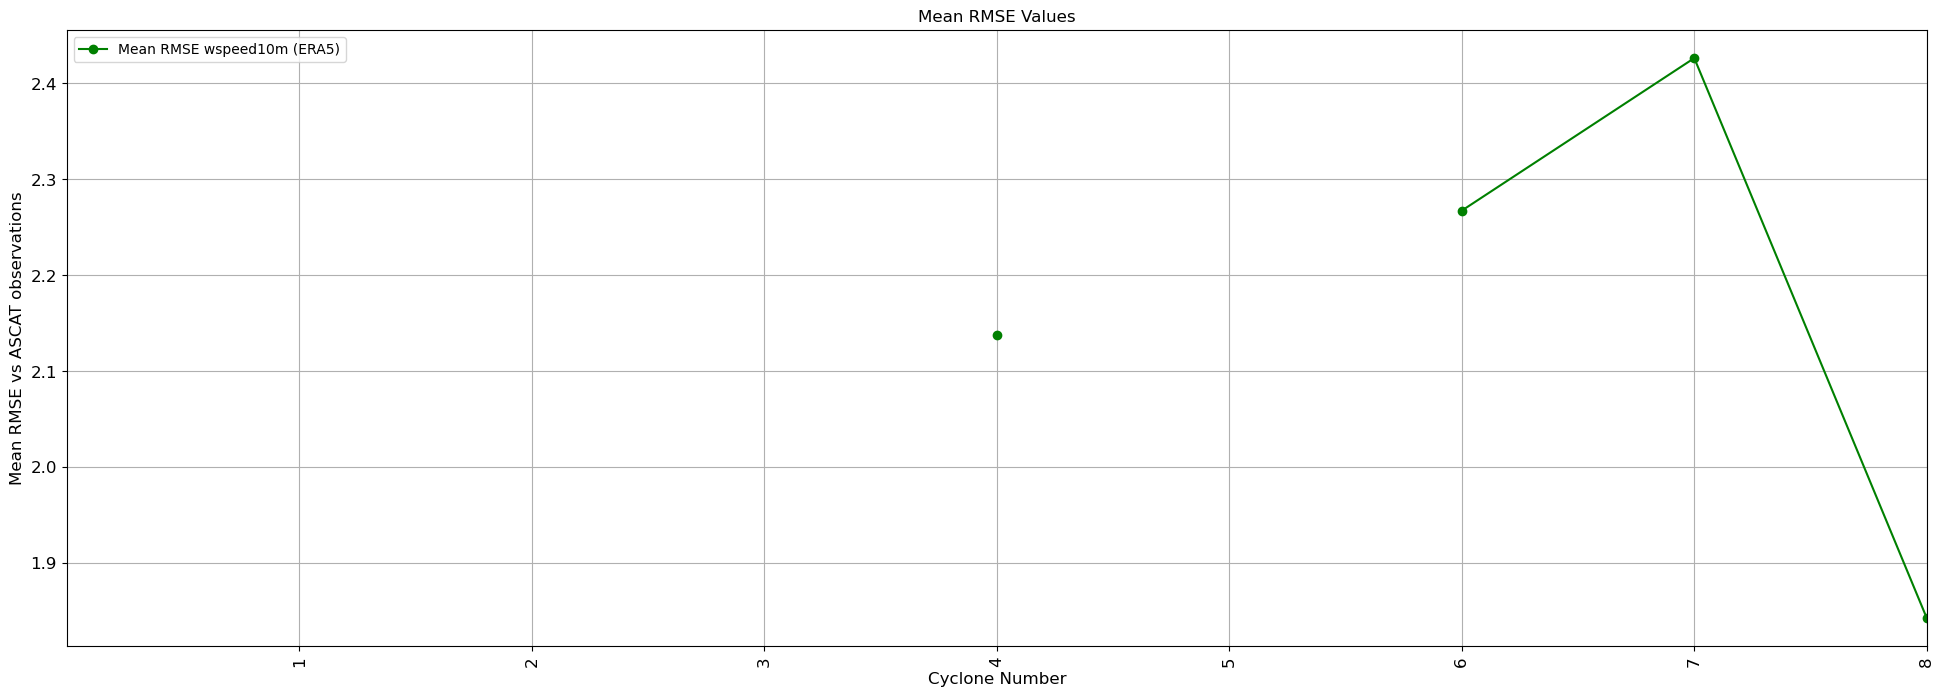

<Figure size 640x480 with 0 Axes>

In [34]:
# Plotting rmse accross different cyclones:
indices = np.arange(len(rmse_era5_wspeed10m_mean))
plt.figure(figsize=(24, 8))
plt.plot(indices+1,rmse_era5_wspeed10m_mean, 'o-', color='green', label='Mean RMSE wspeed10m (ERA5)')
plt.title('Mean RMSE Values',fontsize=12)
plt.xlabel('Cyclone Number',fontsize=12)
plt.ylabel('Mean RMSE vs ASCAT observations',fontsize=12)
plt.grid(True)
plt.xticks(indices+1,fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.xlim([0,len(indices)])
plt.legend()
plt.show()
# Save the figure
plt.savefig('RMSE_WindSpeed10m_ERA5_ASCAT_Cyclones.png', dpi=300)

# -------------------------------------------------------------------------------------------

#### TESTS: Computing RMSE wind speed 10m using ONLY WRF data:

In [35]:
def Computing_WRF_RMSE_and_Plotting_Winds(ASCAT_path,file_name_ASCAT,WRF_path,file_name_WRF):
    #
    # Loading ASCAT geographical coordinates:
    #
    ascat_obs       = Dataset(ASCAT_path + '/' + file_name_ASCAT)
    lat_obs         = ascat_obs['lat'][:,:].data
    lon_obs         = ascat_obs['lon'][:,:].data
    ascat_wspeed10m = ascat_obs['wind_speed'][:,:].data  # Replace 'variable_name' with the actual variable
    ascat_wdir10m   = ascat_obs['wind_dir'][:,:].data  # Replace 'variable_name' with the actual variable
    #
    # Loading WRF geographical coordinates:
    #
    data_wrf   = Dataset(WRF_path + '/' + file_name_WRF)
    lat_wrf    = data_wrf['XLAT'][0,:,:].data
    lon_wrf    = data_wrf['XLONG'][0,:,:].data
    u10m_wrf   = data_wrf['U10'][0,:,:].data
    v10m_wrf   = data_wrf['V10'][0,:,:].data
    wspeed_wrf = np.sqrt(u10m_wrf**2 + v10m_wrf**2)
    #
    # Define the bounding box for the model domain:
    #
    wrf_lat_min, wrf_lat_max = np.min(lat_wrf), np.max(lat_wrf)
    wrf_lon_min, wrf_lon_max = np.min(lon_wrf), np.max(lon_wrf)
    #
    # Define mask and apply it to the observations:
    #
    mask_obs = (lat_obs >= wrf_lat_min) & (lat_obs <= wrf_lat_max) & (lon_obs >= wrf_lon_min) & (lon_obs <= wrf_lon_max) & (ascat_wspeed10m >= -500)
    lat_obs_filtered         = lat_obs[mask_obs]
    lon_obs_filtered         = lon_obs[mask_obs]
    ascat_wspeed10m_filtered = ascat_wspeed10m[mask_obs]
    ascat_wdir10m_filtered   = ascat_wdir10m[mask_obs]
    #
    # Flatten the filtered observation and model grids for interpolation:
    #
    points_obs  = np.c_[lon_obs_filtered.flatten(), lat_obs_filtered.flatten()]
    points_wrf  = np.c_[lon_wrf.flatten(), lat_wrf.flatten()]
    values_wrf  = wspeed_wrf.flatten()
    points_mesh = np.c_[lon_obs_filtered.flatten(), lat_obs_filtered.flatten()]
    #
    # Interpolate wrf onto the observation grid:
    #
    wrf_interp = griddata(points_wrf, values_wrf, points_mesh, method='nearest', fill_value=np.nan)
    #
    #
    # Interpolate u and v components of WRF wind to observation sites:
    #
    u10m_wrf_interp = griddata(points_wrf, u10m_wrf.flatten(), points_mesh, method='nearest', fill_value=np.nan)
    v10m_wrf_interp = griddata(points_wrf, v10m_wrf.flatten(), points_mesh, method='nearest', fill_value=np.nan)
    #
    # =========================================================
    # Compute RMSE:
    # =========================================================
    # Remove NaN values for RMSE computation
    valid_mask = ~np.isnan(wrf_interp) & ~np.isnan(ascat_wspeed10m_filtered)
    wrf_interp_valid      = wrf_interp[valid_mask]
    ascat_wspeed10m_valid = ascat_wspeed10m_filtered[valid_mask]
    ascat_u10m            = ascat_wspeed10m_filtered * np.cos(np.radians(90 - ascat_wdir10m_filtered))
    ascat_v10m            = ascat_wspeed10m_filtered * np.sin(np.radians(90 - ascat_wdir10m_filtered))
    #
    rmse_wspeed10m        = np.sqrt(np.mean((wrf_interp_valid - ascat_wspeed10m_valid) ** 2))
    rmse_u10m             = np.sqrt(np.mean((u10m_wrf_interp - ascat_u10m) ** 2))
    rmse_v10m             = np.sqrt(np.mean((v10m_wrf_interp - ascat_v10m) ** 2))
    #
    print(f'RMSE wspeed10m between model and observations: {rmse_wspeed10m:.2f} m/s')
    print(f'RMSE u10m between model and observations: {rmse_u10m:.2f} m/s')
    print(f'RMSE v10m between model and observations: {rmse_v10m:.2f} m/s')
    #
    return rmse_wspeed10m, rmse_u10m, rmse_v10m

In [37]:
def Interpolation_WRF_and_RMSE(earliest_date,latest_date,cyc_num,mapa):
    start_year    = f"{earliest_date.year:04d}"
    start_month   = f"{earliest_date.month:02d}"
    start_day     = f"{earliest_date.day:02d}"
    start_hour    = f"{earliest_date.hour:02d}"
    start_minute  = "00"
    start_seconds = "00"
    #
    end_year    = f"{latest_date.year:04d}"
    end_month   = f"{latest_date.month:02d}"
    end_day     = f"{latest_date.day:02d}"
    end_hour    = f"{latest_date.hour:02d}"
    end_minute  = "00"
    end_seconds = "00"
    #
    start_YMD_date    = earliest_date.strftime("%Y-%m-%d")
    end_YMD_date      = f"{end_year}{end_month}{end_day}"
    start_date_format = f"{start_year}-{start_month}-{start_day}T{start_hour}:{start_minute}:{start_seconds}"
    end_date_format   = f"{end_year}-{end_month}-{end_day}T{end_hour}:{end_minute}:{end_seconds}"
    day_of_the_year = earliest_date.timetuple().tm_yday
    filename = f"cmems_obs-wind_CYC_{cyc_num:04d}.nc"
    #
    # Initializing lists:
    rmse_wspeed10m_cyc      = []
    rmse_u10m_cyc           = []
    rmse_v10m_cyc           = []
    import datetime as datetime2
    if earliest_date < datetime2.datetime(2010, 7, 1) or latest_date > datetime2.datetime(2021, 12, 1):
        print("EUMETSAT Data is only available from 1 July 2010 onwards.")
        print("EUMETSAT Data for cyclone #"+str(cyc_num)+" will be not obtained.")
        rmse_wspeed10m_cyc.append(np.nan)
    else:
        #
        # Reading ASCAT observations:
        #
        print("ASCAT observations available in the COPERNICUS database.")
        folder_EUMETSAT_path = '/scratch/bidc/DCC/EUMETSAT_Obs'
        file_EUMETSAT_path = f"{folder_EUMETSAT_path}/{start_year}/CYC_{cyc_num}/{day_of_the_year:03d}"
        folder_wrf_path = '/scratch/bidc/DCC/medTRACK_{:04d}/'.format(cyc_num)
        # Selecting the ASCAT files available at the same Cyclone period of time
        for date in date_list:
            print('  Date: ', date)
            filename_wrf = f"medCYC_{cyc_num:04d}_d02_{date.year}-{date.month:02d}-{date.day:02d}_{date.hour:02d}_00_00"
            folder_EUMETSAT_path = '/scratch/bidc/DCC/EUMETSAT_Obs'
            day_of_the_year = date.timetuple().tm_yday
            file_EUMETSAT_path = f"{folder_EUMETSAT_path}/{start_year}/CYC_{cyc_num}/{day_of_the_year:03d}"
            print('  File EUMETSAT path: ',  file_EUMETSAT_path)
            print('  Day of the year: ',  day_of_the_year)
            files_ascat = os.listdir(file_EUMETSAT_path)
            # Let's select the ascat file closer to the time of the cyclone:
            for file in files_ascat:
                if file.startswith(f"ascat_{date.year}{date.month:02d}{date.day:02d}_{date.hour:02d}"):
                    print('      ASCAT file found matching cyclone time:', file)
                    # Here goes CODE to check if ASCAT observations fall within model domain:
                    fraction_obs_within_wrf = ASCAT_Availability_Check(file_EUMETSAT_path,file,folder_wrf_path,filename_wrf)
                    print(f"          Fraction of observations within model domain: {fraction_obs_within_wrf:.2%}")
                    if fraction_obs_within_wrf < 0.04:
                        print('          There are NO enough ASCAT observations in the nested WRF domain to be considered. We neglect this ASCAT file!')
                    else:
                        print('          There are ENOUGH ASCAT observations in the nested WRF domain to be considered. We proceed with the interpolation!')
                        print('          Plotting ASCAT observations and nested WRF domain coverage')
                        Plot_Check_ASCATvsWRF(mapa,file_EUMETSAT_path,file,folder_wrf_path,filename_wrf,cyc_num,date)
                        [ rmse_wspeed10m, rmse_u10m, rmse_v10m ] = Computing_WRF_RMSE_and_Plotting_Winds(file_EUMETSAT_path,file,folder_wrf_path,filename_wrf)
                        rmse_wspeed10m_cyc.append(rmse_wspeed10m)
                        rmse_u10m_cyc.append(rmse_u10m)
                        rmse_v10m_cyc.append(rmse_v10m)
    print('rmse_wspeed10m_cyc: ', rmse_wspeed10m_cyc)
    return rmse_wspeed10m_cyc,rmse_u10m_cyc,rmse_v10m_cyc

In [ ]:
import sys
import os

#cyc_tot = 201    # Entire cyclones database
cyc_tot = 10    # Entire cyclones database

mapa_d02 = Basemap(projection='robin', resolution='c', lon_0=0)

# Initializing lists:
rmse_era5_wspeed10m_cyc_array = []
rmse_era5_u10m_cyc_array      = []
rmse_era5_v10m_cyc_array      = []

for cyc_num in range(1,cyc_tot):
    print ('') 
    print('CYCLONE NUMBER: ', cyc_num)
 
    # Folder WRF path:
    folder_wrf_path = '/scratch/bidc/DCC/medTRACK_{:04d}/'.format(cyc_num)

    # Select range of times for each Cyclone simulation:
    [files, earliest_date,latest_date] = get_cyclone_dates(folder_wrf_path, cyc_num)

    # Generate Dates every hour:
    date_list = generate_dates(earliest_date,latest_date)
    
    if cyc_num > 8:
        break
    
    # Interpolating Copernicus and ERA5 fields to WRF nested domain:
    rmse_wspeed10m_cyc,rmse_u10m_cyc,rmse_v10m_cyc = Interpolation_WRF_and_RMSE(earliest_date,latest_date,cyc_num,mapa_d02)
    rmse_wspeed10m_cyc_array.append(rmse_wspeed10m_cyc)
    rmse_u10m_cyc_array.append(rmse_u10m_cyc)
    rmse_v10m_cyc_array.append(rmse_v10m_cyc)


In [39]:
# Calculate the mean of each sublist ignoring NaN values:
rmse_wrf_wspeed10m_mean = [np.nanmean(sublist) for sublist in rmse_wspeed10m_cyc_array]
rmse_wrf_u10m_mean      = [np.nanmean(sublist) for sublist in rmse_u10m_cyc_array]
rmse_wrf_v10m_mean      = [np.nanmean(sublist) for sublist in rmse_v10m_cyc_array]

print("Means of each WRF wspdeed10m sublist:", rmse_wrf_wspeed10m_mean)
print("Means of each WRF u10m sublist:", rmse_wrf_u10m_mean)
print("Means of each WRF v10m sublist:", rmse_wrf_v10m_mean)

Means of each WRF wspdeed10m sublist: [nan, nan, nan, 3.8582881289943725, nan, 2.95311492489113, 4.25603612313725, 4.488273379709002]
Means of each WRF u10m sublist: [nan, nan, nan, 4.830679546148174, nan, 4.775919469601365, 5.619084891169176, 5.056992855102595]
Means of each WRF v10m sublist: [nan, nan, nan, 4.571905184354109, nan, 4.768347652983646, 5.821245212814686, 5.058751783882343]


/etc/ecmwf/ssd/ssd1/tmpdirs/bidc.1009146.20240627_120011.612/ipykernel_1032472/303538295.py:2: RuntimeWarning: Mean of empty slice
  rmse_wrf_wspeed10m_mean = [np.nanmean(sublist) for sublist in rmse_wspeed10m_cyc_array]
/etc/ecmwf/ssd/ssd1/tmpdirs/bidc.1009146.20240627_120011.612/ipykernel_1032472/303538295.py:3: RuntimeWarning: Mean of empty slice
  rmse_wrf_u10m_mean      = [np.nanmean(sublist) for sublist in rmse_u10m_cyc_array]
/etc/ecmwf/ssd/ssd1/tmpdirs/bidc.1009146.20240627_120011.612/ipykernel_1032472/303538295.py:4: RuntimeWarning: Mean of empty slice
  rmse_wrf_v10m_mean      = [np.nanmean(sublist) for sublist in rmse_v10m_cyc_array]


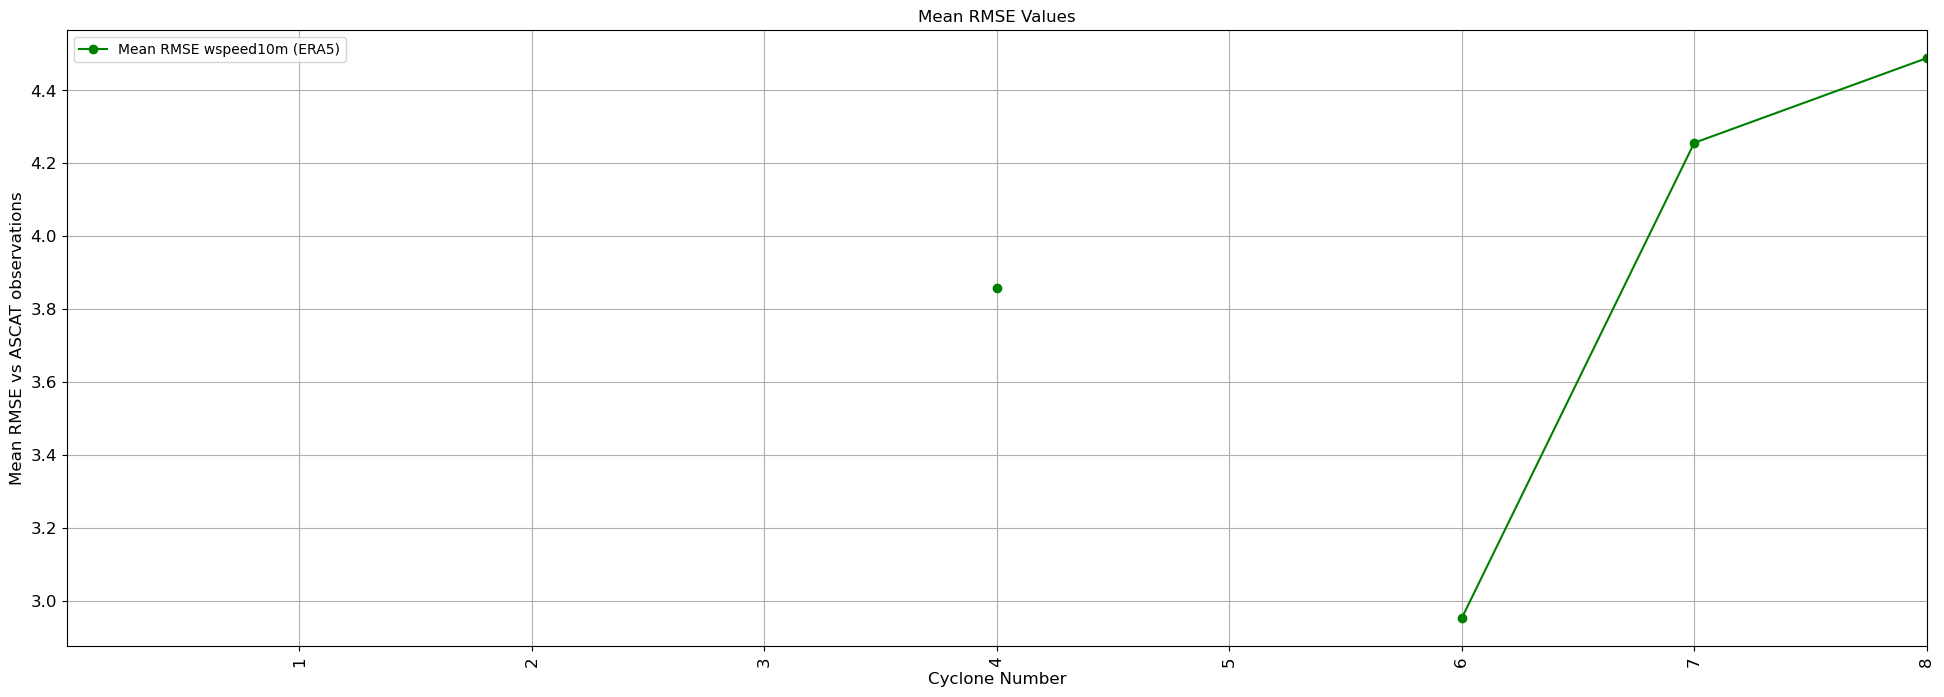

<Figure size 640x480 with 0 Axes>

In [40]:
# Plotting rmse accross different cyclones:
indices = np.arange(len(rmse_era5_wspeed10m_mean))
plt.figure(figsize=(24, 8))
plt.plot(indices+1,rmse_wrf_wspeed10m_mean, 'o-', color='green', label='Mean RMSE wspeed10m (ERA5)')
plt.title('Mean RMSE Values',fontsize=12)
plt.xlabel('Cyclone Number',fontsize=12)
plt.ylabel('Mean RMSE vs ASCAT observations',fontsize=12)
plt.grid(True)
plt.xticks(indices+1,fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.xlim([0,len(indices)])
plt.legend()
plt.show()
# Save the figure
plt.savefig('RMSE_WindSpeed10m_WRF_ASCAT_Cyclones.png', dpi=300)

# --------------------------------------------------------------------------------

#### Loading FULL DATASET (200 CYCLONES) using pickle:

In [18]:
# Loading FULL dataset cyclones using pickle. This data has been obtained running a python program (EUMETSAT_Obs_Interpolation.py) in ATOS-ECMWF.
#
# WRF dataset:
#
with open('rmse_wspeed10m_cyc_array.pkl', 'rb') as f:
    rmse_wspeed10m_cyc_array = pickle.load(f)
with open('rmse_u10m_cyc_array.pkl', 'rb') as f:
    rmse_u10m_cyc_array      = pickle.load(f)
with open('rmse_v10m_cyc_array.pkl', 'rb') as f:
    rmse_v10m_cyc_array      = pickle.load(f)
#
# ERA5 dataset:
#    
with open('rmse_era5_wspeed10m_cyc_array.pkl', 'rb') as f:
    rmse_era5_wspeed10m_cyc_array = pickle.load(f)
with open('rmse_era5_u10m_cyc_array.pkl', 'rb') as f:
    rmse_era5_u10m_cyc_array = pickle.load(f)
with open('rmse_era5_v10m_cyc_array.pkl', 'rb') as f:
    rmse_era5_v10m_cyc_array = pickle.load(f)


#### Calculate the MEAN of each RMSE sublist associated with each Cyclone ignoring NaN values:

In [19]:
# Calculate the mean of each sublist ignoring NaN values:
rmse_wspeed10m_mean      = [np.nanmean(sublist) for sublist in rmse_wspeed10m_cyc_array]
rmse_u10m_mean           = [np.nanmean(sublist) for sublist in rmse_u10m_cyc_array]
rmse_v10m_mean           = [np.nanmean(sublist) for sublist in rmse_v10m_cyc_array]
rmse_era5_wspeed10m_mean = [np.nanmean(sublist) for sublist in rmse_era5_wspeed10m_cyc_array]
rmse_era5_u10m_mean      = [np.nanmean(sublist) for sublist in rmse_era5_u10m_cyc_array]
rmse_era5_v10m_mean      = [np.nanmean(sublist) for sublist in rmse_era5_v10m_cyc_array]
print("Means of each wspdeed10m sublist:", rmse_wspeed10m_mean)
print("Means of each u10m sublist:", rmse_u10m_mean)
print("Means of each v10m sublist:", rmse_v10m_mean)
print("Means of each ERA5 wspdeed10m sublist:", rmse_era5_wspeed10m_mean)
print("Means of each ERA5 u10m sublist:", rmse_era5_u10m_mean)
print("Means of each ERA5 v10m sublist:", rmse_era5_v10m_mean)

Means of each wspdeed10m sublist: [nan, nan, nan, 3.8582881289943725, nan, 2.95311492489113, 4.25603612313725, 4.488273379709002, 5.373334270077761, 3.5434627590387215, nan, nan, 3.7017337955721428, nan, 4.126468058942659, nan, 2.910622438593336, 2.4635613011003, nan, 3.302776675705476, 3.055866450084171, 3.833291166857136, nan, nan, 4.06930352578828, nan, 3.5486238044735114, 4.6891958336178945, 2.755191753705584, 4.304043837527797, 3.97045317360454, nan, nan, nan, 3.5522143491089215, 2.7733004680554254, nan, 3.4017182502319043, nan, 3.996532419840133, nan, 3.3875691376392525, 4.676695735139768, 3.654311193514976, nan, nan, nan, 3.24513370881935, nan, nan, nan, 4.167314381207434, 3.2120706416318567, 2.573710966287347, 3.91192462197542, nan, nan, nan, 4.7950661444835605, nan, 4.084489981127507, nan, nan, 2.9737538185428902, nan, 3.7106019526180143, 3.634432172803124, nan, 2.7956230511927065, 3.0306627153250125, 3.2735747573689262, 3.3884310479804904, nan, 3.0970315132261295, nan, 4.7832

/etc/ecmwf/ssd/ssd1/tmpdirs/bidc.3890296.20240627_100437.944/ipykernel_3940446/3589813007.py:2: RuntimeWarning: Mean of empty slice
  rmse_wspeed10m_mean      = [np.nanmean(sublist) for sublist in rmse_wspeed10m_cyc_array]
/etc/ecmwf/ssd/ssd1/tmpdirs/bidc.3890296.20240627_100437.944/ipykernel_3940446/3589813007.py:3: RuntimeWarning: Mean of empty slice
  rmse_u10m_mean           = [np.nanmean(sublist) for sublist in rmse_u10m_cyc_array]
/etc/ecmwf/ssd/ssd1/tmpdirs/bidc.3890296.20240627_100437.944/ipykernel_3940446/3589813007.py:4: RuntimeWarning: Mean of empty slice
  rmse_v10m_mean           = [np.nanmean(sublist) for sublist in rmse_v10m_cyc_array]
/etc/ecmwf/ssd/ssd1/tmpdirs/bidc.3890296.20240627_100437.944/ipykernel_3940446/3589813007.py:5: RuntimeWarning: Mean of empty slice
  rmse_era5_wspeed10m_mean = [np.nanmean(sublist) for sublist in rmse_era5_wspeed10m_cyc_array]
/etc/ecmwf/ssd/ssd1/tmpdirs/bidc.3890296.20240627_100437.944/ipykernel_3940446/3589813007.py:6: RuntimeWarning: M

#### Plotting RMSE accross different cyclones:

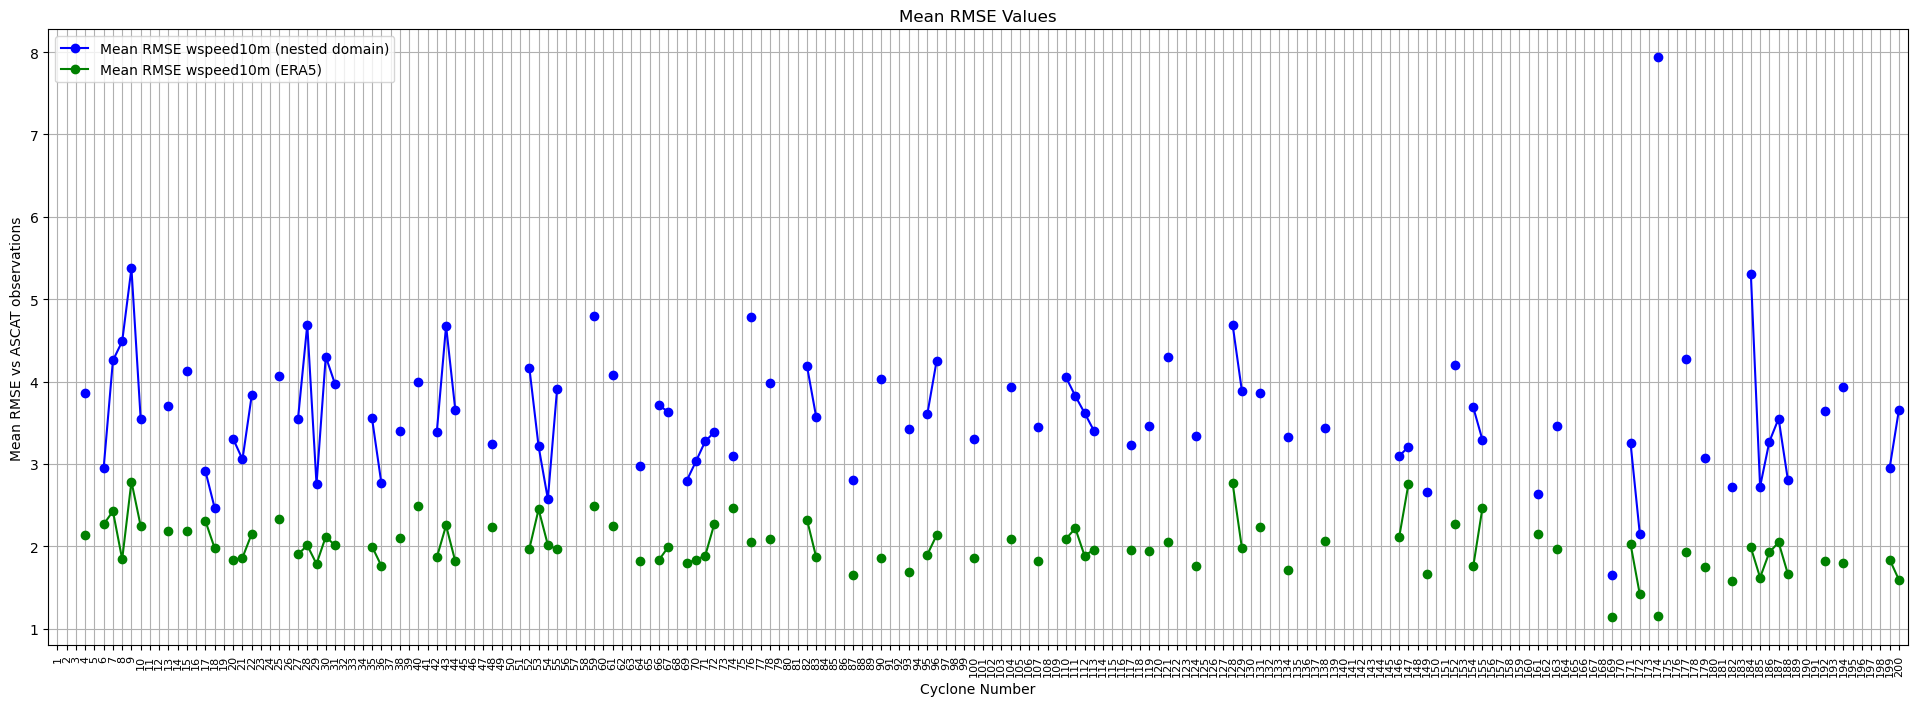

<Figure size 640x480 with 0 Axes>

In [33]:
# Plotting rmse accross different cyclones:
indices = np.arange(len(rmse_wspeed10m_mean))
plt.figure(figsize=(24, 8))
plt.plot(indices+1,rmse_wspeed10m_mean, 'o-', color='blue', label='Mean RMSE wspeed10m (nested domain)')
plt.plot(indices+1,rmse_era5_wspeed10m_mean, 'o-', color='green', label='Mean RMSE wspeed10m (ERA5)')
plt.title('Mean RMSE Values')
plt.xlabel('Cyclone Number')
plt.ylabel('Mean RMSE vs ASCAT observations')
plt.grid(True)
plt.xticks(indices+1,fontsize=8, rotation=90)
plt.yticks(fontsize=10)
plt.xlim([0,201])
plt.legend()
plt.show()
# Save the figure
plt.savefig('RMSE_WindSpeed10m_ASCAT_Cyclones.png', dpi=300)

#### Plotting wind speed at 10m together with 10m wind x- and y-components:

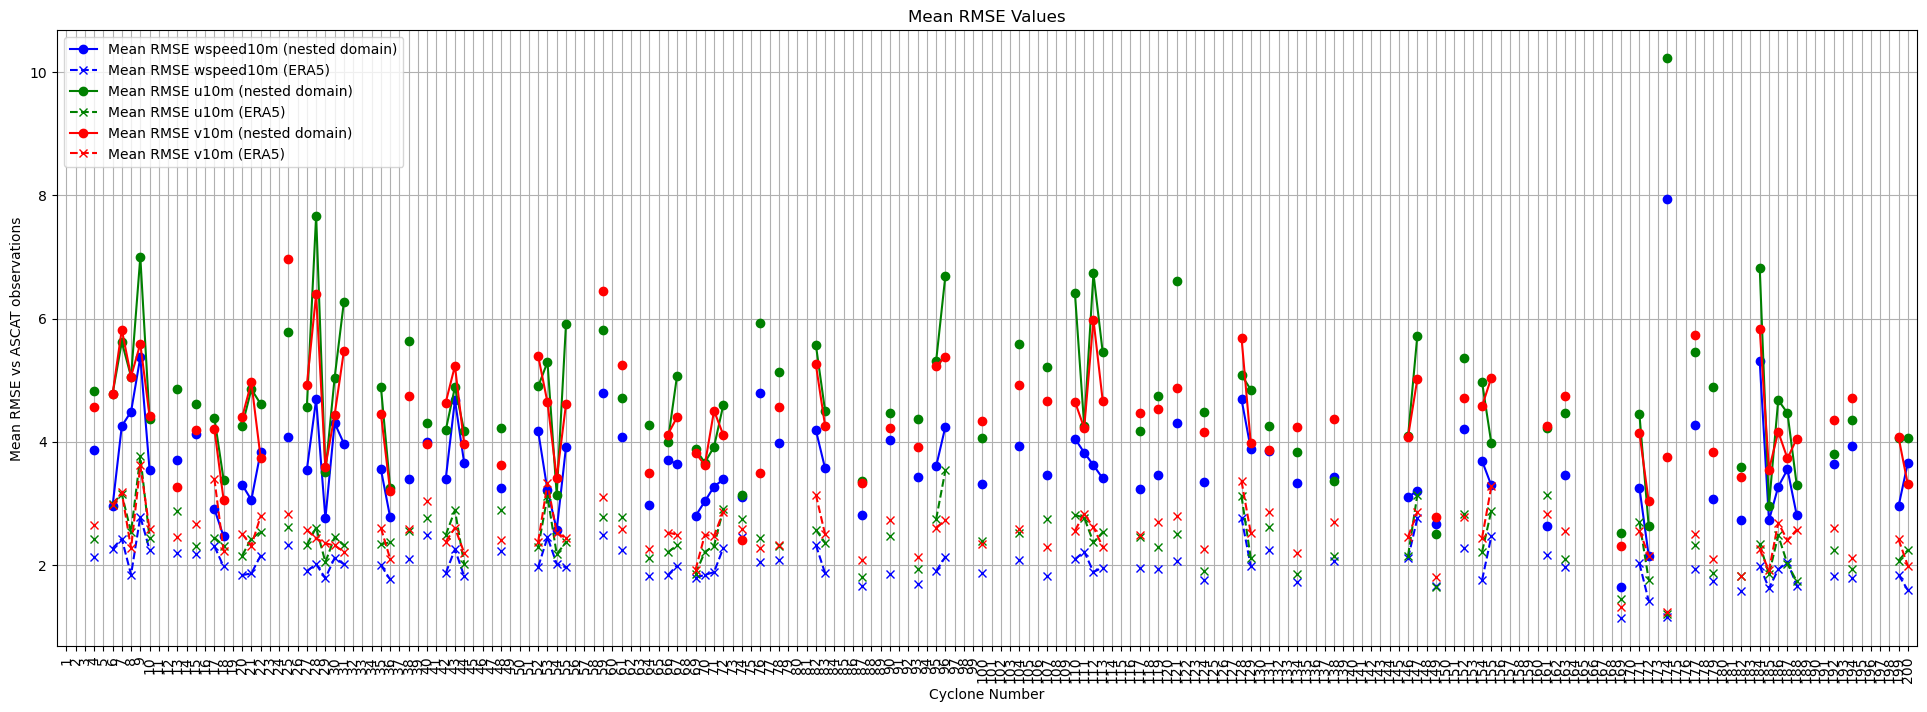

<Figure size 640x480 with 0 Axes>

In [30]:
# Plotting rmse accross different cyclones:
indices = np.arange(len(rmse_wspeed10m_mean))
plt.figure(figsize=(24, 8))
plt.plot(indices+1,rmse_wspeed10m_mean, 'o-', color='blue', label='Mean RMSE wspeed10m (nested domain)')
plt.plot(indices+1,rmse_era5_wspeed10m_mean, 'x--', color='blue', label='Mean RMSE wspeed10m (ERA5)')
plt.plot(indices+1,rmse_u10m_mean, 'o-', color='green', label='Mean RMSE u10m (nested domain)')
plt.plot(indices+1,rmse_era5_u10m_mean, 'x--', color='green', label='Mean RMSE u10m (ERA5)')
plt.plot(indices+1,rmse_v10m_mean, 'o-', color='red',label='Mean RMSE v10m (nested domain)')
plt.plot(indices+1,rmse_era5_v10m_mean, 'x--', color='red', label='Mean RMSE v10m (ERA5)')
plt.title('Mean RMSE Values')
plt.xlabel('Cyclone Number')
plt.ylabel('Mean RMSE vs ASCAT observations')
plt.grid(True)
plt.xticks(indices+1,fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.xlim([0,201])
plt.legend()
plt.show()
# Save the figure
plt.savefig('RMSE_ASCAT_Cyclones.png', dpi=300)

# ------------------------------------------------------------------------------------------

# ANNEX:

#### Counting number of observations falling within numerical domain:

Total number of ASCAT observations in the globe:  (3163, 82) 259366
Size ASCAT wind speed values: (3163, 82)
Size wrf domain:  (360, 360)
Number of ASCAT observations within numerical model:  346
Minimum and Maximum values of ASCAT observations:  4.74 24.88
Valid mask size:  (461,) (9535,)
Valid obs size:  461 9996
Fraction of observations within mesh domain:  0.04611844737895158
Fraction of observations within mesh domain: 4.61%


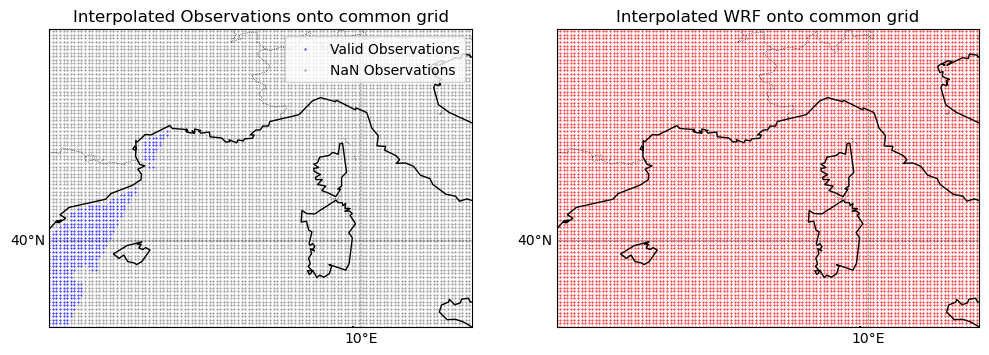

In [12]:
import numpy as np
from scipy.interpolate import griddata
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.spatial import cKDTree

# Paths and filenames
ASCAT_path      = '/scratch/bidc/DCC/EUMETSAT_Obs/2012/CYC_4/333'
file_name_ASCAT = 'ascat_20121128_095700_metopa_31706_eps_o_coa_2101_ovw.l2.nc'
WRF_path        = '/scratch/bidc/DCC/medTRACK_0004/'
file_name_WRF   = 'medCYC_0004_d02_2012-11-28_09_00_00'

# Loading ASCAT geographical coordinates
ascat_obs    = Dataset(ASCAT_path + '/' + file_name_ASCAT)
lat_obs      = ascat_obs['lat'][:,:].data
lon_obs      = ascat_obs['lon'][:,:].data
ascat_values = ascat_obs['wind_speed'][:,:].data  # Replace 'variable_name' with the actual variable
print('Total number of ASCAT observations in the globe: ', np.shape(lat_obs), lat_obs.size)
print('Size ASCAT wind speed values:', np.shape(ascat_values))

# Loading WRF geographical coordinates
data_wrf   = Dataset(WRF_path + '/' + file_name_WRF)
lat_wrf    = data_wrf['XLAT'][0,:,:].data
lon_wrf    = data_wrf['XLONG'][0,:,:].data
u10m_wrf   = data_wrf['U10'][0,:,:].data
v10m_wrf   = data_wrf['V10'][0,:,:].data
wspeed_wrf = np.sqrt(u10m_wrf**2 + v10m_wrf**2)
print('Size wrf domain: ', np.shape(lat_wrf))

# Define the bounding box for the model domain
wrf_lat_min, wrf_lat_max = np.min(lat_wrf), np.max(lat_wrf)
wrf_lon_min, wrf_lon_max = np.min(lon_wrf), np.max(lon_wrf)

# Filter observations within the model domain
mask_obs = (lat_obs >= wrf_lat_min) & (lat_obs <= wrf_lat_max) & (lon_obs >= wrf_lon_min) & (lon_obs <= wrf_lon_max) & (ascat_values >= -500)
lat_obs_filtered      = lat_obs[mask_obs]
lon_obs_filtered      = lon_obs[mask_obs]
ascat_values_filtered = ascat_values[mask_obs]
print('Number of ASCAT observations within numerical model: ', lat_obs_filtered.size)
print('Minimum and Maximum values of ASCAT observations: ', np.min(ascat_values_filtered),np.max(ascat_values_filtered))


# Interpolate to a common grid to compute later the fraction of observations that covers the numerical domain:
#x_reg           = np.linspace(wrf_lon_min,wrf_lon_max,np.shape(lon_wrf)[0])
#y_reg           = np.linspace(wrf_lat_min,wrf_lat_max,np.shape(lat_wrf)[0])
x_reg           = np.arange(wrf_lon_min,wrf_lon_max,0.11)  # 0.11 degrees ~ 12 km
y_reg           = np.arange(wrf_lat_min,wrf_lat_max,0.11)  # 0.11 degrees ~ 12 km
lon_reg,lat_reg = np.meshgrid(x_reg,y_reg)
#print('lat_reg:', lat_reg[0,0:10],np.shape(lat_reg))
#print('lon_reg:', lon_reg[0,0:10],np.shape(lon_reg))

# Flatten the filtered observation and model grids for interpolation
points_obs  = np.c_[lon_obs_filtered.flatten(), lat_obs_filtered.flatten()]
points_wrf  = np.c_[lon_wrf.flatten(), lat_wrf.flatten()]
##values_obs  = ascat_values_filtered.flatten()
values_obs  = np.ones(lon_obs_filtered.flatten().shape)  # Dummy values to represent points

values_wrf  = wspeed_wrf.flatten()
points_mesh = np.c_[lon_reg.flatten(), lat_reg.flatten()]
#print(np.shape(points_obs),np.shape(values_obs),np.shape(points_mesh))

# Interpolate observations onto the common grid
grid_obs_common = griddata(points_obs, values_obs, points_mesh, method='nearest', fill_value=np.nan)
grid_obs_mesh   = grid_obs_common.reshape(lat_reg.shape)
#print('grid_obs_mesh: ', grid_obs_mesh, np.min(grid_obs_mesh), np.max(grid_obs_mesh))

# Calculate distances to the nearest observation point
tree = cKDTree(points_obs)
distances, _ = tree.query(points_mesh, k=1)
distance_threshold = 0.1  # Set an appropriate threshold distance

# Mask the interpolated grid based on the distance to the nearest observation point
grid_obs_mesh[distances.reshape(lat_reg.shape) > distance_threshold] = np.nan
#print('grid_obs_mesh: ', grid_obs_mesh, np.min(grid_obs_mesh), np.max(grid_obs_mesh))

# Separate valid and NaN values
valid_mask       = ~np.isnan(grid_obs_mesh)
nan_mask         = np.isnan(grid_obs_mesh)
x_valid, y_valid = lon_reg[valid_mask], lat_reg[valid_mask]
x_nan, y_nan     = lon_reg[nan_mask], lat_reg[nan_mask]
print('Valid mask size: ', np.shape(x_valid),np.shape(x_nan))

#
#                       
# Check the fraction of observation points within the model domain
#
total_mesh_points      = lon_reg.size
fraction_within_mesh = np.sum(x_valid.size) / total_mesh_points
print('Valid obs size: ', x_valid.size, total_mesh_points)
print('Fraction of observations within mesh domain: ', fraction_within_mesh)
print(f"Fraction of observations within mesh domain: {fraction_within_mesh:.2%}")

#
# Interpolate WRF onto the common grid
grid_wrf_common = griddata(points_wrf, values_wrf, points_mesh, method='nearest', fill_value=np.nan)
grid_wrf_mesh   = grid_wrf_common.reshape(lat_reg.shape)
#print('grid_wrf_mesh: ', grid_wrf_mesh, np.nanmax(grid_wrf_mesh))

# =========================================================
# Plotting:
# =========================================================
# Create the Basemap instance
m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=wrf_lat_min, urcrnrlat=wrf_lat_max,
            llcrnrlon=wrf_lon_min, urcrnrlon=wrf_lon_max)

# Plotting the data
fig = plt.figure(figsize=(12,14))
ax = fig.add_subplot(121)
m.drawcoastlines(color="black", linewidth=1)
m.drawstates(linestyle="dotted")
m.drawcountries(linestyle="dotted")
parallels = np.arange(-90, 90, 10)
meridians = np.arange(0, 360, 10)
m.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10, linewidth=0.5)
m.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10, linewidth=0.5)
# Transform coordinates for plotting
x_reg, y_reg = m(lon_reg, lat_reg)
x_obs, y_obs = m(lon_obs_filtered, lat_obs_filtered)

# Scatter plot the values
m.scatter(x_valid, y_valid, color='blue', s=0.2, label='Valid Observations')
m.scatter(x_nan, y_nan, color='grey', s=0.2, label='NaN Observations')
plt.legend(loc='upper right')
plt.title('Interpolated Observations onto common grid')
#
ax = fig.add_subplot(122)
m.drawcoastlines(color="black", linewidth=1)
m.drawstates(linestyle="dotted")
m.drawcountries(linestyle="dotted")
parallels = np.arange(-90, 90, 10)
meridians = np.arange(0, 360, 10)
m.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10, linewidth=0.5)
m.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10, linewidth=0.5)
# Transform coordinates for plotting
x_wrf, y_wrf = m(lon_reg, lat_reg)
# Plot the observation points in blue
m.scatter(x_reg, y_reg, color='red', s=0.2, label='Observations')
plt.title('Interpolated WRF onto common grid')
plt.show()

#### Here goes CODE to plot ASCAT observations and comparing with model:

In [25]:
def Computing_RMSE_and_Plotting_Winds(ASCAT_path,file_name_ASCAT,WRF_path,file_name_WRF):
    #
    # Loading ASCAT geographical coordinates:
    #
    ascat_obs       = Dataset(ASCAT_path + '/' + file_name_ASCAT)
    lat_obs         = ascat_obs['lat'][:,:].data
    lon_obs         = ascat_obs['lon'][:,:].data
    ascat_wspeed10m = ascat_obs['wind_speed'][:,:].data  # Replace 'variable_name' with the actual variable
    ascat_wdir10m   = ascat_obs['wind_dir'][:,:].data  # Replace 'variable_name' with the actual variable
    #print('Total number of ASCAT observations in the globe: ', np.shape(lat_obs), lat_obs.size)
    #print('Size ASCAT wind speed values:', np.shape(ascat_wspeed10m))
    #
    # Loading WRF geographical coordinates:
    #
    data_wrf   = Dataset(WRF_path + '/' + file_name_WRF)
    lat_wrf    = data_wrf['XLAT'][0,:,:].data
    lon_wrf    = data_wrf['XLONG'][0,:,:].data
    u10m_wrf   = data_wrf['U10'][0,:,:].data
    v10m_wrf   = data_wrf['V10'][0,:,:].data
    wspeed_wrf = np.sqrt(u10m_wrf**2 + v10m_wrf**2)
    #print('Size wrf domain: ', np.shape(lat_wrf))
    #
    # Define the bounding box for the model domain:
    #
    wrf_lat_min, wrf_lat_max = np.min(lat_wrf), np.max(lat_wrf)
    wrf_lon_min, wrf_lon_max = np.min(lon_wrf), np.max(lon_wrf)
    #
    # Define mask and apply it to the observations:
    #
    mask_obs = (lat_obs >= wrf_lat_min) & (lat_obs <= wrf_lat_max) & (lon_obs >= wrf_lon_min) & (lon_obs <= wrf_lon_max) & (ascat_wspeed10m >= -500)
    lat_obs_filtered         = lat_obs[mask_obs]
    lon_obs_filtered         = lon_obs[mask_obs]
    ascat_wspeed10m_filtered = ascat_wspeed10m[mask_obs]
    ascat_wdir10m_filtered   = ascat_wdir10m[mask_obs]
    #print('Number of ASCAT observations within numerical model: ', lat_obs_filtered.size)
    #
    # Flatten the filtered observation and model grids for interpolation:
    #
    points_obs  = np.c_[lon_obs_filtered.flatten(), lat_obs_filtered.flatten()]
    points_wrf  = np.c_[lon_wrf.flatten(), lat_wrf.flatten()]
    values_wrf  = wspeed_wrf.flatten()
    points_mesh = np.c_[lon_obs_filtered.flatten(), lat_obs_filtered.flatten()]
    #
    # Interpolate wrf onto the observation grid:
    #
    wrf_interp = griddata(points_wrf, values_wrf, points_mesh, method='nearest', fill_value=np.nan)
    #
    # Interpolate u and v components of WRF wind to observation sites:
    #
    u10m_wrf_interp = griddata(points_wrf, u10m_wrf.flatten(), points_mesh, method='nearest', fill_value=np.nan)
    v10m_wrf_interp = griddata(points_wrf, v10m_wrf.flatten(), points_mesh, method='nearest', fill_value=np.nan)
    #print('wrf_interp: ', np.shape(wrf_interp), wrf_interp)
    #print('ascat_wspeed10m_filtered: ', np.shape(ascat_wspeed10m_filtered), ascat_wspeed10m_filtered)
    #
    # =========================================================
    # Compute RMSE:
    # =========================================================
    # Remove NaN values for RMSE computation
    valid_mask = ~np.isnan(wrf_interp) & ~np.isnan(ascat_wspeed10m_filtered)
    wrf_interp_valid = wrf_interp[valid_mask]
    ascat_wspeed10m_valid = ascat_wspeed10m_filtered[valid_mask]
    ascat_u10m = ascat_wspeed10m_filtered * np.cos(np.radians(90 - ascat_wdir10m_filtered))
    ascat_v10m = ascat_wspeed10m_filtered * np.sin(np.radians(90 - ascat_wdir10m_filtered))
    #
    rmse_wspeed10m = np.sqrt(np.mean((wrf_interp_valid - ascat_wspeed10m_valid) ** 2))
    rmse_u10m = np.sqrt(np.mean((u10m_wrf_interp - ascat_u10m) ** 2))
    rmse_v10m = np.sqrt(np.mean((v10m_wrf_interp - ascat_v10m) ** 2))
    #
    print(f'RMSE wspeed10m between model and observations: {rmse_wspeed10m:.2f} m/s')
    print(f'RMSE u10m between model and observations: {rmse_u10m:.2f} m/s')
    print(f'RMSE v10m between model and observations: {rmse_v10m:.2f} m/s')
    #
    # =========================================================
    # Plotting:
    # =========================================================
    #
    # Create the Basemap instance:
    m = Basemap(projection='cyl', resolution='i',
                llcrnrlat=wrf_lat_min, urcrnrlat=wrf_lat_max,
                llcrnrlon=wrf_lon_min, urcrnrlon=wrf_lon_max)
    #
    # Plotting the data:
    #
    fig = plt.figure(figsize=(14, 10))
    #
    # First subplot: Observed wind speed and direction:
    # 
    ax1 = fig.add_subplot(121)
    m.drawcoastlines(color="black", linewidth=1)
    m.drawstates(linestyle="dotted")
    m.drawcountries(linestyle="dotted")
    parallels = np.arange(-90, 90, 10)
    meridians = np.arange(0, 360, 10)
    m.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10, linewidth=0.5)
    m.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10, linewidth=0.5)
    #
    # Transform coordinates for plotting:
    #
    x_obs, y_obs = m(lon_obs_filtered, lat_obs_filtered)
    #
    # Calculate u and v components for observed wind:
    #
    u_obs = ascat_wspeed10m_filtered * np.cos(np.radians(90 - ascat_wdir10m_filtered))
    v_obs = ascat_wspeed10m_filtered * np.sin(np.radians(90 - ascat_wdir10m_filtered))
    #
    # Plot wind barbs for observed wind speed and direction:
    #
    #m.barbs(x_obs, y_obs, u_obs, v_obs, length=5, color='blue')
    barb_density = 3  # Controls the density of barbs
    m.barbs(x_obs[::barb_density], y_obs[::barb_density], u_obs[::barb_density], v_obs[::barb_density], length=5, color='blue')
    plt.title('Observed Wind Speed and Direction')
    #
    # Second subplot: Interpolated WRF wind speed and direction:
    #
    ax2 = fig.add_subplot(122)
    m.drawcoastlines(color="black", linewidth=1)
    m.drawstates(linestyle="dotted")
    m.drawcountries(linestyle="dotted")
    m.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10, linewidth=0.5)
    m.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10, linewidth=0.5)
    # Plot wind barbs for interpolated WRF wind speed and direction
    #m.barbs(x_obs, y_obs, u10m_wrf_interp, v10m_wrf_interp, length=5, color='red')
    barb_density = 3  # Controls the density of barbs
    m.barbs(x_obs[::barb_density], y_obs[::barb_density], u10m_wrf_interp[::barb_density], v10m_wrf_interp[::barb_density], length=5, color='red')
    plt.title('Interpolated WRF Wind Speed and Direction')
    plt.tight_layout()
    plt.show()


RMSE wspeed10m between model and observations: 5.73 m/s
RMSE u10m between model and observations: 6.18 m/s
RMSE v10m between model and observations: 3.24 m/s


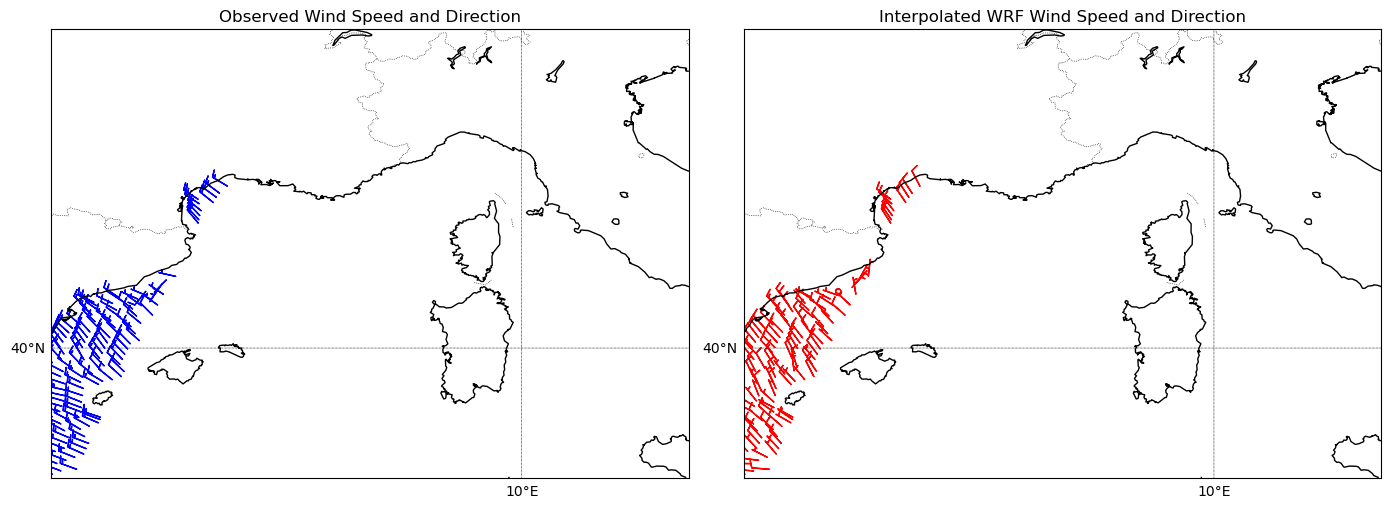

In [26]:
# Paths and filenames:
ASCAT_path      = '/scratch/bidc/DCC/EUMETSAT_Obs/2012/CYC_4/333'
file_name_ASCAT = 'ascat_20121128_095700_metopa_31706_eps_o_coa_2101_ovw.l2.nc'
WRF_path        = '/scratch/bidc/DCC/medTRACK_0004/'
file_name_WRF   = 'medCYC_0004_d02_2012-11-28_09_00_00'

Computing_RMSE_and_Plotting_Winds(ASCAT_path,file_name_ASCAT,WRF_path,file_name_WRF)

Total number of ASCAT observations in the globe:  (3163, 82) 259366
Size ASCAT wind speed values: (3163, 82)
Size wrf domain:  (360, 360)
Number of ASCAT observations within numerical model:  346
wrf_interp:  (346,) [ 8.110783    8.2354      7.986858   10.227591   10.156092   12.235825
 10.837571   13.052031    9.859118   14.033384   10.256579    9.478677
  9.331203   11.76396    12.152874   11.852872   11.684579   14.896764
 14.914767   14.645651   16.85521    17.352737   17.270788   18.31261
 17.757788   16.768867   17.159674   15.539258   15.061492    3.9420223
  3.4275      2.4208844   3.5927403   3.3152373   5.086283    3.162266
  3.3296933   4.6690135   3.185206    2.8440535   0.83429885  1.6430361
  2.6402783   2.8289566   2.382805    1.9321305   4.304133    3.6897833
  2.7486722   3.512989    3.7767606   4.3653955   4.600862    5.740526
  5.904644    4.6192884   4.5925946   6.581224    7.0473056   6.374102
  6.827295    5.7961287   6.288136    5.9876733   8.967135    7.813149
 

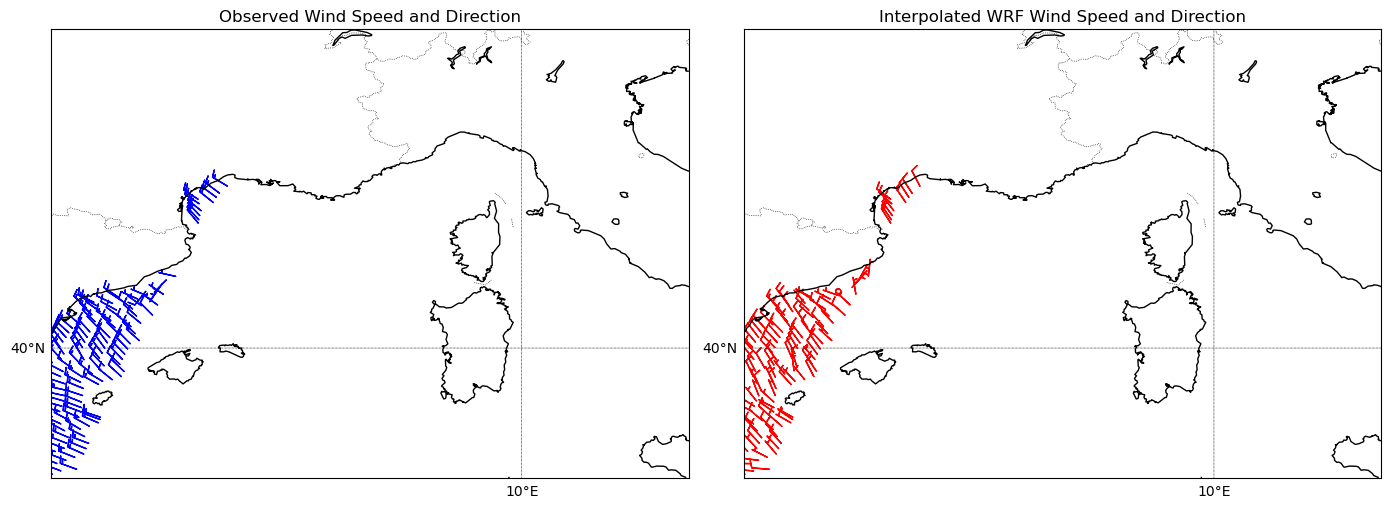

In [14]:
# Paths and filenames:
ASCAT_path      = '/scratch/bidc/DCC/EUMETSAT_Obs/2012/CYC_4/333'
file_name_ASCAT = 'ascat_20121128_095700_metopa_31706_eps_o_coa_2101_ovw.l2.nc'
WRF_path        = '/scratch/bidc/DCC/medTRACK_0004/'
file_name_WRF   = 'medCYC_0004_d02_2012-11-28_09_00_00'

# Loading ASCAT geographical coordinates:
ascat_obs       = Dataset(ASCAT_path + '/' + file_name_ASCAT)
lat_obs         = ascat_obs['lat'][:,:].data
lon_obs         = ascat_obs['lon'][:,:].data
ascat_wspeed10m = ascat_obs['wind_speed'][:,:].data  # Replace 'variable_name' with the actual variable
ascat_wdir10m   = ascat_obs['wind_dir'][:,:].data  # Replace 'variable_name' with the actual variable

print('Total number of ASCAT observations in the globe: ', np.shape(lat_obs), lat_obs.size)
print('Size ASCAT wind speed values:', np.shape(ascat_values))

# Loading WRF geographical coordinates:
data_wrf   = Dataset(WRF_path + '/' + file_name_WRF)
lat_wrf    = data_wrf['XLAT'][0,:,:].data
lon_wrf    = data_wrf['XLONG'][0,:,:].data
u10m_wrf   = data_wrf['U10'][0,:,:].data
v10m_wrf   = data_wrf['V10'][0,:,:].data
wspeed_wrf = np.sqrt(u10m_wrf**2 + v10m_wrf**2)
print('Size wrf domain: ', np.shape(lat_wrf))

# Define the bounding box for the model domain:
wrf_lat_min, wrf_lat_max = np.min(lat_wrf), np.max(lat_wrf)
wrf_lon_min, wrf_lon_max = np.min(lon_wrf), np.max(lon_wrf)

# Define mask and apply it to the observations:
mask_obs = (lat_obs >= wrf_lat_min) & (lat_obs <= wrf_lat_max) & (lon_obs >= wrf_lon_min) & (lon_obs <= wrf_lon_max) & (ascat_values >= -500)
lat_obs_filtered         = lat_obs[mask_obs]
lon_obs_filtered         = lon_obs[mask_obs]
ascat_wspeed10m_filtered = ascat_wspeed10m[mask_obs]
ascat_wdir10m_filtered   = ascat_wdir10m[mask_obs]
print('Number of ASCAT observations within numerical model: ', lat_obs_filtered.size)

# Flatten the filtered observation and model grids for interpolation
points_obs  = np.c_[lon_obs_filtered.flatten(), lat_obs_filtered.flatten()]
points_wrf  = np.c_[lon_wrf.flatten(), lat_wrf.flatten()]
values_wrf  = wspeed_wrf.flatten()
points_mesh = np.c_[lon_obs_filtered.flatten(), lat_obs_filtered.flatten()]

# Interpolate wrf onto the observation grid
wrf_interp = griddata(points_wrf, values_wrf, points_mesh, method='nearest', fill_value=np.nan)

# Interpolate u and v components of WRF wind to observation sites
u10m_wrf_interp = griddata(points_wrf, u10m_wrf.flatten(), points_mesh, method='nearest', fill_value=np.nan)
v10m_wrf_interp = griddata(points_wrf, v10m_wrf.flatten(), points_mesh, method='nearest', fill_value=np.nan)

print('wrf_interp: ', np.shape(wrf_interp), wrf_interp )
print('ascat_wspeed10m_filtered: ', np.shape(ascat_wspeed10m_filtered), ascat_wspeed10m_filtered )

# =========================================================
# Plotting
# =========================================================

# Create the Basemap instance
m = Basemap(projection='cyl', resolution='i',
            llcrnrlat=wrf_lat_min, urcrnrlat=wrf_lat_max,
            llcrnrlon=wrf_lon_min, urcrnrlon=wrf_lon_max)


# Plotting the data
fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(121)
m.drawcoastlines(color="black", linewidth=1)
m.drawstates(linestyle="dotted")
m.drawcountries(linestyle="dotted")
parallels = np.arange(-90, 90, 10)
meridians = np.arange(0, 360, 10)
m.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10, linewidth=0.5)
m.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10, linewidth=0.5)
#
# Transform coordinates for plotting
x_obs, y_obs = m(lon_obs_filtered, lat_obs_filtered)
#
# Calculate u and v components for observed wind
u_obs = ascat_wspeed10m_filtered * np.cos(np.radians(90 - ascat_wdir10m_filtered))
v_obs = ascat_wspeed10m_filtered * np.sin(np.radians(90 - ascat_wdir10m_filtered))
#
# Plot wind barbs for observed wind speed and direction
barb_density = 3  # Controls the density of barbs
m.barbs(x_obs[::barb_density], y_obs[::barb_density], u_obs[::barb_density], v_obs[::barb_density], length=5, color='blue')
plt.title('Observed Wind Speed and Direction')
#
# Second subplot: Interpolated WRF wind speed and direction
#
ax2 = fig.add_subplot(122)
m.drawcoastlines(color="black", linewidth=1)
m.drawstates(linestyle="dotted")
m.drawcountries(linestyle="dotted")
m.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10, linewidth=0.5)
m.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10, linewidth=0.5)
#
# Plot wind barbs for interpolated WRF wind speed and direction
# Plot barbs
m.barbs(x_obs[::barb_density], y_obs[::barb_density], u10m_wrf_interp[::barb_density], v10m_wrf_interp[::barb_density], length=5, color='red')
plt.title('Interpolated WRF Wind Speed and Direction')
plt.tight_layout()
plt.show()

Total number of ASCAT observations in the globe:  (3163, 82) 259366
Size ASCAT wind speed values: (3163, 82)
Size wrf domain:  (360, 360)
region_mask:  (3163, 82)
(3163, 82) (3163, 82)
shape wspeed10m_filtered_smoothed:  (3163, 82) (346,)
shape u10m:  (3163, 82) (346,) (346,)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


(<matplotlib.quiver.Barbs at 0x154f24869e20>,
 <matplotlib.quiver.Barbs at 0x154f2448bdf0>)

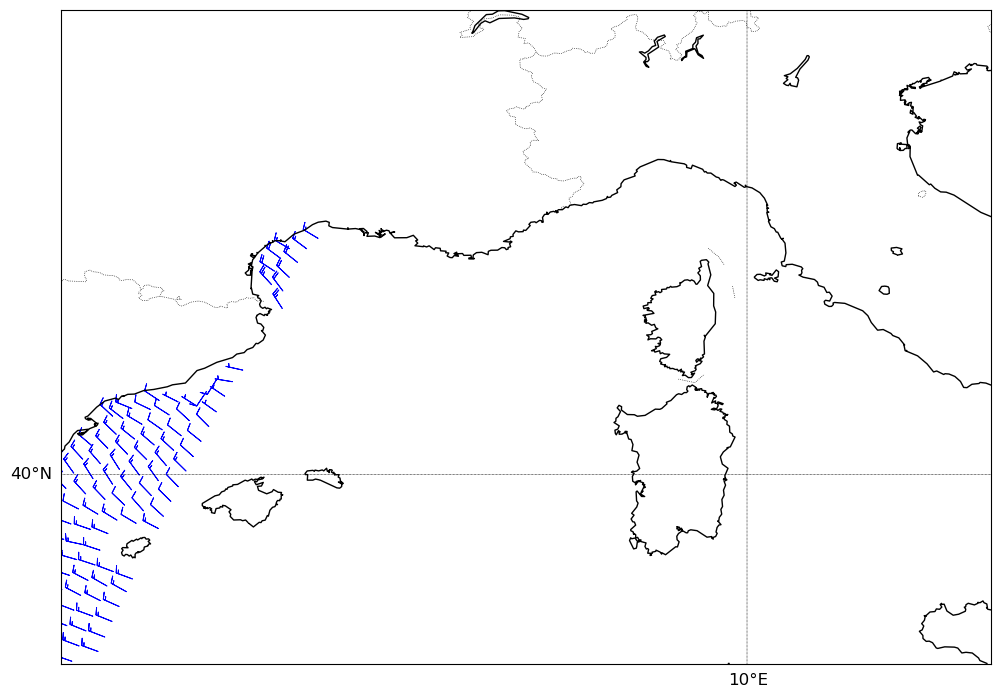

In [15]:
# Paths and filenames
ASCAT_path      = '/scratch/bidc/DCC/EUMETSAT_Obs/2012/CYC_4/333'
file_name_ASCAT = 'ascat_20121128_095700_metopa_31706_eps_o_coa_2101_ovw.l2.nc'
WRF_path        = '/scratch/bidc/DCC/medTRACK_0004/'
file_name_WRF   = 'medCYC_0004_d02_2012-11-28_09_00_00'

# Loading ASCAT geographical coordinates
ascat_obs       = Dataset(ASCAT_path + '/' + file_name_ASCAT)
lat_obs         = ascat_obs['lat'][:,:].data
lon_obs         = ascat_obs['lon'][:,:].data
ascat_wspeed10m = ascat_obs['wind_speed'][:,:].data  # Replace 'variable_name' with the actual variable
ascat_wdir10m   = ascat_obs['wind_dir'][:,:].data  # Replace 'variable_name' with the actual variable

print('Total number of ASCAT observations in the globe: ', np.shape(lat_obs), lat_obs.size)
print('Size ASCAT wind speed values:', np.shape(ascat_values))

# Loading WRF geographical coordinates
data_wrf   = Dataset(WRF_path + '/' + file_name_WRF)
lat_wrf    = data_wrf['XLAT'][0,:,:].data
lon_wrf    = data_wrf['XLONG'][0,:,:].data
u10m_wrf   = data_wrf['U10'][0,:,:].data
v10m_wrf   = data_wrf['V10'][0,:,:].data
wspeed_wrf = np.sqrt(u10m_wrf**2 + v10m_wrf**2)
print('Size wrf domain: ', np.shape(lat_wrf))

# Define the bounding box for the model domain
wrf_lat_min, wrf_lat_max = np.min(lat_wrf), np.max(lat_wrf)
wrf_lon_min, wrf_lon_max = np.min(lon_wrf), np.max(lon_wrf)

# Create masks for the region of interest
lat_mask = (lat_obs >= wrf_lat_min) & (lat_obs <= wrf_lat_max)
lon_mask = (lon_obs >= wrf_lon_min) & (lon_obs <= wrf_lon_max)
region_mask = lat_mask & lon_mask
print('region_mask: ', np.shape(region_mask))

valid_mask = ascat_wspeed10m >= -500
combined_mask = region_mask & valid_mask

# Filter the wind speed data and set the invalid points to NaN
wspeed10m_filtered = np.where(combined_mask, ascat_wspeed10m, np.nan)
wdir10m_filtered   = np.where(combined_mask, ascat_wdir10m, np.nan)

# Apply Gaussian filter on the 2D wind speed array
wspeed10m_filtered_smoothed = gaussian_filter(wspeed10m_filtered, sigma=0)
wdir10m_filtered_smoothed   = gaussian_filter(wdir10m_filtered, sigma=0)


# Create the Basemap instance
m = Basemap(projection='cyl', resolution='i',
            llcrnrlat=wrf_lat_min, urcrnrlat=wrf_lat_max,
            llcrnrlon=wrf_lon_min, urcrnrlon=wrf_lon_max)

print(np.shape(lon_obs),np.shape(wspeed10m_filtered_smoothed))

# Create the figure with a larger size for better visualization
fig = plt.figure(figsize=(12, 14))
ax = fig.add_subplot(111)

# Customize the map details
parallels = np.arange(-90, 90, 10)
meridians = np.arange(0, 360, 10)
m.drawcoastlines(color="black", linewidth=1)
m.drawstates(linestyle="dotted")
m.drawcountries(linestyle="dotted")
m.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=12, linewidth=0.5)
m.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=12, linewidth=0.5)


# Transform coordinates for plotting
x_v, y_v = m(lon_obs, lat_obs)


# Getting minimum and maximum values wind speed at 10m:
wind_max = int(np.nanmax(wspeed10m_filtered_smoothed))
wind_min = 0

# Contour levels
clevs = np.arange(wind_min, wind_max, 1)

#print(np.shape(x_v),np.shape(wspeed10m_filtered_smoothed))

# Create filled contours
#cs1 = m.contourf(x_v, y_v, wspeed10m_filtered_smoothed, clevs, cmap='rainbow', extend='max')

# Add a color bar for wind speed
#cbar = m_d01.colorbar(cs1, location='bottom', pad="5%")
#cbar.set_label('Wind Speed (m/s)')


print('shape wspeed10m_filtered_smoothed: ', np.shape(wspeed10m_filtered_smoothed),np.shape(ascat_wdir10m_filtered))


# Calculate the U and V wind components
u10m = wspeed10m_filtered_smoothed * np.cos(np.radians(270 - wdir10m_filtered_smoothed))
v10m = wspeed10m_filtered_smoothed * np.sin(np.radians(270 - wdir10m_filtered_smoothed))
u10m = wspeed10m_filtered_smoothed * np.cos(np.radians(90 - wdir10m_filtered_smoothed))
v10m = wspeed10m_filtered_smoothed * np.sin(np.radians(90 - wdir10m_filtered_smoothed))

print('shape u10m: ', np.shape(u10m),np.shape(ascat_wspeed10m_filtered),np.shape(ascat_wdir10m_filtered))
print(wspeed10m_filtered)
# Filter the wind speed data and set the invalid points to NaN
#u10m_filtered = np.where(combined_mask, u10m, np.nan)
#v10m_filtered = np.where(combined_mask, v10m, np.nan)

# Plot barbs
barb_density = 2  # Controls the density of barbs
m.barbs(x_v[::barb_density, ::barb_density], y_v[::barb_density, ::barb_density], 
            u10m[::barb_density, ::barb_density], v10m[::barb_density, ::barb_density], 
            length=5, linewidth=0.7, color='blue')

#### Obtaining variables of interest from ERA5 files:

In [88]:
#Opening ERA5 Grib files:
ds = xr.open_dataset('/scratch/bidc/DCC/CYC_150/ERA5_AN_19961202_0000_sfc', engine='cfgrib',backend_kwargs={'errors': 'ignore'})

# Obtaining variables of interest from ERA5 files:
lat_era5 = ds['latitude']
lon_era5 = ds['longitude']
u10_era5 = ds['u10']
v10_era5 = ds['v10']

# Computing wind speed:
wind_speed_era5 = np.sqrt(u10_era5**2 + v10_era5**2)

# Transform 1-dim lon_era5 and lat_era5 arrays to 2-dim arrays:
[lons_era5,lats_era5] = np.meshgrid(lon_era5,lat_era5)

#### Creating Basemap:

In [90]:
proj, moad_cen_lat, cen_lat, cen_lon, truelat1, truelat2, standlon = "lcc", 38, 38, 12, 34, 36, 12
x_dim, y_dim = 650, 350
dx, dy = 9000, 9000
width_meters, height_meters = dx * (x_dim - 1), dy * (y_dim - 1) 
    
m_d01 = Basemap(resolution="c",projection=proj,rsphere=6370000.,width=width_meters,height=height_meters,lat_0=cen_lat,lon_0=cen_lon,lat_1=truelat1,lat_2=truelat2,area_thresh=100.) 

#### Plotting Figure:

Text(0.5, 1.0, 'ERA5 Wind Speed at 10 m')

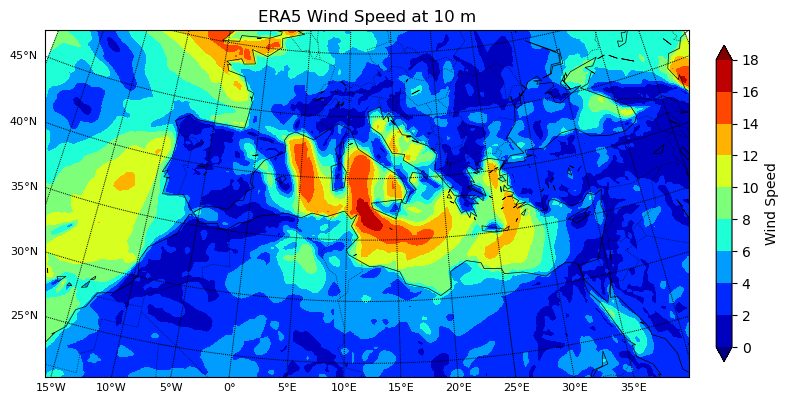

In [91]:
from matplotlib import cm
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(221)
parallels = np.arange(-90,90,5)
meridians = np.arange(0,360,5)
m_d01.drawcoastlines(color="black",linewidth=0.5)
m_d01.drawstates(linestyle="dotted")
m_d01.drawcountries(linestyle="dotted")
m_d01.drawparallels(parallels,labels=[1,0,0,0],fontsize=8,linewidth=.7)
m_d01.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8,linewidth=.7)
x, y = m_d01(lons_era5,lats_era5) # compute map proj coordinates of the grid points
clevs=np.arange(0,20,2)
cs1 = m_d01.contourf(x,y,wind_speed_era5,clevs,cmap=plt.cm.jet,extend='both')
plt.colorbar(cs1, label= 'Wind Speed',fraction=0.023,pad=0.04)
fig.tight_layout()
plt.title('ERA5 Wind Speed at 10 m')
